In [231]:
# Zachary Katz
# zachary_katz@mines.edu
# 27 May 2025

"""
Test ha.ipynb to reproduce and diagnose errors in tide height from ICESat-2 harmonic analysis
"""

# Extensions
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.optimize import least_squares
import pandas as pd
import scipy


import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import Tides.Tides as Tides
import datetime
from pyproj import CRS, Transformer
import cartopy.crs as ccrs

import shapely
from shapely.geometry import MultiPolygon
import shapefile


def ll2xy(lon, lat):
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y)
    Can also take lists of floats!

    Parameters
    lon - Geodetic longitude in EPSG:4326 [float]
    lat - Geodetic latitude in EPSG:4326 [float]

    Returns
    x - Antarctic Polar Stereographic (EPSG:3031) x [float]
    y - Antarctic Polar Stereographic (EPSG:3031) y [float]
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Satellite repeat times [hr]
HR_IN_DAY = 24
SEC_IN_HR = 3600
T_icesat2 = 90.8193 * HR_IN_DAY  # 90.8193 days in hrs (From ATL03 POD ATBD)
T_swot = 20.86455 * HR_IN_DAY  # 21 days in hrs
T_cryosat_subcycle = 28.941 * HR_IN_DAY  # 28 days in hrs
T_jason = 9.9156 * HR_IN_DAY  # 9 days in hrs

# Tidal constituents [hr]
M2 = 12.4206012
S2 = 12
N2 = 12.65834751
K2 = 11.96723606

K1 = 23.9344721
O1 = 25.81933871
P1 = 24.06588766
Q1 = 26.868350

constituents = {
    "M2": M2,
    "S2": S2,
    "N2": N2,
    "K2": K2,
    "K1": K1,
    "O1": O1,
    "P1": P1,
    "Q1": Q1,
}

In [ ]:
def tide_model(t, periods, parameters):
    """
    Generate the tide from synthetic data.

    Parameters
    ----------
    t : List
        List of sampling times in hours
    periods : dict
        Dictionary of tidal constituent periods in hours
    parameters : list
        List in form [A1, A2, ... , phi_1, phi_2, ...]
        where A is the amplitude in m and phi is the phase shift in radians

    Returns
    -------
    modeled : list
        Tides at time t as estimated by the model
    """
    assert len(parameters) == 2 * len(
        periods
    ), "Parameters must be twice the number of periods"

    model = np.zeros_like(t, dtype=float)
    n = len(periods)
    for i in range(n):
        A = parameters[i]
        phi = parameters[i + n]
        model += A * np.cos(2 * np.pi * t / periods[i] - phi)
    return model


def residuals(parameters, t, data, periods):
    """
    Residual function for scipy's least_squares
    Scipy does the squaring for us.
    """
    return tide_model(t, periods, parameters) - data

In [11]:
# Try with IceSat-2 crossover at gz05
# User-defined path
data_path = "../data/ATL11/"

# Download ATL11 if necessary
granule_names = [
    "ATL11_134011_0326_006_12.h5",
    "ATL11_102111_0326_006_12.h5",
    "ATL11_112111_0326_006_12.h5",
    "ATL11_107511_0326_006_12.h5",
    "ATL11_138711_0326_006_12.h5",
]
for granule_name in granule_names:
    results = earthaccess.search_data(
        short_name="ATL11",
        granule_name=granule_name,
    )
    print(results)
    earthaccess.download(results, data_path, provider="POCLOUD")
files = list(Path(data_path).glob("*.h5"))

[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -153.59526, 'Latitude': -78.98162}, {'Longitude': -153.87878, 'Latitude': -78.9677}, {'Longitude': -153.99141, 'Latitude': -78.98917}, {'Longitude': -155.48991, 'Latitude': -80.24384}, {'Longitude': -160.10742, 'Latitude': -82.8004}, {'Longitude': -164.22914, 'Latitude': -84.16105}, {'Longitude': 178.20076, 'Latitude': -86.664}, {'Longitude': 157.00415, 'Latitude': -87.60905}, {'Longitude': 88.84637, 'Latitude': -87.43669}, {'Longitude': 56.05837, 'Latitude': -84.17317}, {'Longitude': 49.46781, 'Latitude': -81.64929}, {'Longitude': 47.27274, 'Latitude': -80.24236}, {'Longitude': 45.77733, 'Latitude': -78.98982}, {'Longitude': 45.71627, 'Latitude': -78.97243}, {'Longitude': 45.60891, 'Latitude': -78.96835}, {'Longitude': 45.53695, 'Latitude': -78.97633}, {'Longitude': 45.24915, 

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 776.72it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5295.84it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 6955.73it/s]


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 179.85048, 'Latitude': -79.62305}, {'Longitude': 175.77768, 'Latitude': -82.2103}, {'Longitude': 167.96292, 'Latitude': -84.72366}, {'Longitude': 147.58093, 'Latitude': -86.9958}, {'Longitude': 89.03956, 'Latitude': -87.90811}, {'Longitude': 44.41772, 'Latitude': -86.3511}, {'Longitude': 35.16444, 'Latitude': -85.15627}, {'Longitude': 26.33484, 'Latitude': -82.74471}, {'Longitude': 20.3503, 'Latitude': -78.98981}, {'Longitude': 20.28922, 'Latitude': -78.97242}, {'Longitude': 20.18185, 'Latitude': -78.96835}, {'Longitude': 20.10973, 'Latitude': -78.97636}, {'Longitude': 19.82096, 'Latitude': -78.98408}, {'Longitude': 19.75899, 'Latitude': -79.01208}, {'Longitude': 23.06214, 'Latitude': -81.55325}, {'Longitude': 28.57619, 'Latitude': -83.92244}, {'Longitude': 41.83464, 'Latitude'

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 706.71it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8867.45it/s]


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -21.12473, 'Latitude': -78.97534}, {'Longitude': -21.25291, 'Latitude': -78.96729}, {'Longitude': -21.36554, 'Latitude': -78.98875}, {'Longitude': -23.0168, 'Latitude': -80.35496}, {'Longitude': -27.98981, 'Latitude': -83.00056}, {'Longitude': -38.32304, 'Latitude': -85.50742}, {'Longitude': -49.33157, 'Latitude': -86.67351}, {'Longitude': -104.84451, 'Latitude': -87.94569}, {'Longitude': -165.13304, 'Latitude': -85.42898}, {'Longitude': -175.45456, 'Latitude': -82.80251}, {'Longitude': 178.4198, 'Latitude': -78.98974}, {'Longitude': 178.35872, 'Latitude': -78.97235}, {'Longitude': 178.25136, 'Latitude': -78.96828}, {'Longitude': 178.17889, 'Latitude': -78.97635}, {'Longitude': 177.88853, 'Latitude': -78.98408}, {'Longitude': 177.82658, 'Latitude': -79.01209}, {'Longitude': -17

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1178.51it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 7584.64it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9554.22it/s]


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -14.63508, 'Latitude': -78.97552}, {'Longitude': -14.76337, 'Latitude': -78.96745}, {'Longitude': -14.876, 'Latitude': -78.98891}, {'Longitude': -18.39584, 'Latitude': -81.55198}, {'Longitude': -21.07863, 'Latitude': -82.83373}, {'Longitude': -31.68911, 'Latitude': -85.48572}, {'Longitude': -41.62631, 'Latitude': -86.58096}, {'Longitude': -95.77303, 'Latitude': -87.94914}, {'Longitude': -146.58118, 'Latitude': -86.71297}, {'Longitude': -158.03256, 'Latitude': -85.52278}, {'Longitude': -168.58549, 'Latitude': -82.95491}, {'Longitude': -173.49702, 'Latitude': -80.314}, {'Longitude': -175.09157, 'Latitude': -78.98952}, {'Longitude': -175.15265, 'Latitude': -78.97213}, {'Longitude': -175.26001, 'Latitude': -78.96806}, {'Longitude': -175.33273, 'Latitude': -78.97618}, {'Longitude': 

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1299.35it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4981.36it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 5833.52it/s]


[Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3B Slope-Corrected Land Ice Height Time Series V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 176.28804, 'Latitude': -78.98149}, {'Longitude': 176.00465, 'Latitude': -78.96754}, {'Longitude': 175.892, 'Latitude': -78.98901}, {'Longitude': 172.38452, 'Latitude': -81.54428}, {'Longitude': 168.45657, 'Latitude': -83.29919}, {'Longitude': 160.69676, 'Latitude': -85.22247}, {'Longitude': 150.58528, 'Latitude': -86.46145}, {'Longitude': 101.29993, 'Latitude': -87.93942}, {'Longitude': 65.69052, 'Latitude': -87.63155}, {'Longitude': 33.44281, 'Latitude': -85.62484}, {'Longitude': 22.31693, 'Latitude': -83.00506}, {'Longitude': 19.45766, 'Latitude': -81.69448}, {'Longitude': 15.68062, 'Latitude': -78.98986}, {'Longitude': 15.61954, 'Latitude': -78.97247}, {'Longitude': 15.51218, 'Latitude': -78.9684}, {'Longitude': 15.44017, 'Latitude': -78.97638}, {'Longitude': 15.15244, 'Lati

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 272.00it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:05<00:00,  5.43s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 7133.17it/s]


In [7]:
# Print available groups from file 1
!h5dump -n {files[0]}

HDF5 "../data/ATL11/ATL11_107511_0326_006_12.h5" {
FILE_CONTENTS {
 group      /
 group      /METADATA
 group      /METADATA/AcquisitionInformation
 group      /METADATA/AcquisitionInformation/lidar
 group      /METADATA/AcquisitionInformation/lidarDocument
 group      /METADATA/AcquisitionInformation/platform
 group      /METADATA/AcquisitionInformation/platformDocument
 group      /METADATA/DataQuality
 group      /METADATA/DataQuality/CompletenessOmission
 group      /METADATA/DataQuality/DomainConsistency
 group      /METADATA/DatasetIdentification
 group      /METADATA/Extent
 group      /METADATA/Lineage
 group      /METADATA/Lineage/ANC36-11
 group      /METADATA/Lineage/ANC38-11
 group      /METADATA/Lineage/ATL06
 group      /METADATA/Lineage/Control
 group      /METADATA/ProcessStep
 group      /METADATA/ProcessStep/Browse
 group      /METADATA/ProcessStep/Metadata
 group      /METADATA/ProcessStep/PGE
 group      /METADATA/ProcessStep/QA
 group      /METADATA/ProductSpecific

In [109]:
# Make array of ATL11 data
data_arr = []

# Each reference track pair is a group
group = ["/pt1/", "/pt2/", "/pt3/"]

# Loop over files
for file in files[:]:
    # Loop over pairs
    for i, g in enumerate(group):
        data = {}
        # Load variables into dictionary list
        with h5py.File(file, "r") as fi:
            data["t_ref"] = fi["/ancillary_data/atlas_sdp_gps_epoch"][
                :
            ]  # ICESat-2 reference epoch
            data["filename"] = file
            data["group"] = g

            # Crossing track data
            data["x_q_flag"] = fi[g + "crossing_track_data/atl06_quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["x_lat"] = fi[g + "crossing_track_data/latitude"][
                :
            ]  # Latitude [degrees]
            data["x_lon"] = fi[g + "crossing_track_data/longitude"][
                :
            ]  # Longitude [degrees]
            data["x_h_corr"] = fi[g + "crossing_track_data/h_corr"][
                :
            ]  # Mean corrected height [m]
            data["x_t_dt"] = fi[g + "crossing_track_data/delta_time"][
                :
            ]  # GPS seconds since reference epoch
            data["x_cycle_number"] = fi[g + "crossing_track_data/cycle_number"][
                :
            ]  # Cycle
            data["x_rgt"] = fi[g + "crossing_track_data/rgt"][
                :
            ]  # Reference ground track
            data["x_spot_crossing"] = fi[g + "crossing_track_data/spot_crossing"][
                :
            ]  # Spot  number
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][
                :
            ]  # Reference point
            data["x_x"], data["x_y"] = ll2xy(data["x_lon"], data["x_lat"])

            time_temp = data["t_ref"] + data["x_t_dt"]
            data["x_time"] = Time(
                time_temp, format="gps"
            ).iso  # Convert to readable time
            data["x_tide"] = fi[
                g + "crossing_track_data/tide_ocean"
            ]  # Not ocean_tide as in the ATBD
            data["x_ref_pt"] = fi[g + "crossing_track_data/ref_pt"][:]
            data["x_dac"] = fi[g + "crossing_track_data/dac"][:]

            # Main track data
            data["lat"] = fi[g + "/latitude"][:]  # Latitude [degrees]
            data["lon"] = fi[g + "/longitude"][:]  # Longitude [degrees]
            data["h_corr"] = fi[g + "/h_corr"][:]  # Mean corrected height [m]
            data["t_dt"] = fi[g + "/delta_time"][:]  # GPS seconds since reference epoch
            data["q_flag"] = fi[g + "/quality_summary"][
                :
            ]  # 0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
            data["cycle_number"] = fi[g + "/cycle_number"][:]  # Cycle
            data["ref_pt"] = fi[g + "/ref_pt"][:]  # Reference point
            time_temp = data["t_ref"] + data["t_dt"]
            data["time"] = Time(time_temp, format="gps").iso  # Convert to readable time
            data["tide"] = fi[g + "/cycle_stats/tide_ocean"][:]  # Tide correction [m]
            data["dac"] = fi[g + "/cycle_stats/dac"][:]

            data["x"], data["y"] = ll2xy(data["lon"], data["lat"])

        data_arr.append(data)

/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/home/zkatz/Research/harmonic-analysis/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.


In [ ]:
ice_shelf_polygons = []
grounded_polygons = []


# Load all polygons and sort based on classification
gl_path = "/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/Antarctica_masks/scripps_antarctica_polygons_v1.shp"  # Path to Grounding Line
sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i] : parts[i + 1]]
        polygon = shapely.Polygon(part)
        if (
            classification == "Isolated island"
            or classification == "Ice rise or connected island"
            or classification == "Grounded ice or land"
        ):
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")

gray_area_union = MultiPolygon(grounded_polygons)

# Get Ross Ice Shelf polygon
bbox = [-200000, -1800000, 0, -800000]  # Ross
# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    classification = record[field_names.index("Id_text")]
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ) and classification == "Ice shelf":
        filtered_records.append(record)
        filtered_shapes.append(shape)


# Plotting polygons helper
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shapez in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shapez.points
        parts = list(shapez.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[0],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                        alpha=0.5,
                    )
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2, transform=transform)
                else:
                    ax.plot(
                        *zip(*part),
                        color=colors[1],
                        linewidth=1.5,
                        zorder=2,
                        transform=transform,
                    )
            else:
                print(f"Unknown classification: {classification}")

15


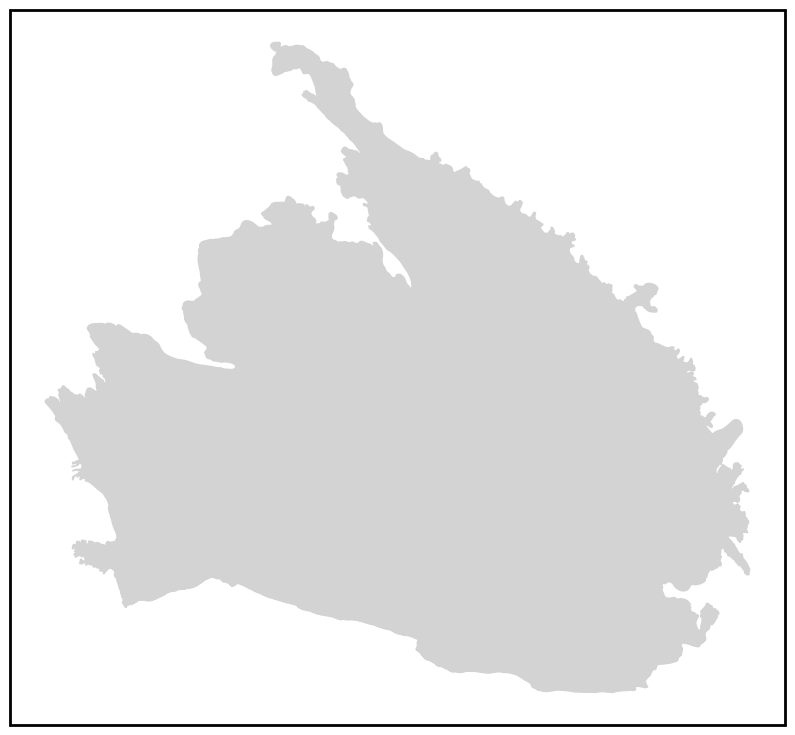

In [149]:
# Manually pick and visualize a few points on each track for testing
from shapely.geometry import Point, shape

print(len(data_arr))
ross = shape(filtered_shapes[0].__geo_interface__)

# Downscale data so only in ross polygon
for data in data_arr[:]:
    inside_mask = []
    x_inside_mask = []
    for xi, yi in zip(data["x"], data["y"]):
        point = Point(xi, yi)
        inside_mask.append(ross.contains(point))
    data["inside_mask"] = inside_mask

    for xi, yi in zip(data["x_x"], data["x_y"]):
        point = Point(xi, yi)
        x_inside_mask.append(ross.contains(point))

    data["x_inside_mask"] = x_inside_mask

ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={"projection": ps71_projection},
)
plot_shapefile(
    filtered_records,
    filtered_shapes,
    ax,
    ["blue", "lightgray"],
    ps71_projection,
    fill=True,
)

In [ ]:
# Make dataframe of all crossovers
crossover_dfs = []

for trk_X in data_arr:
    for ref_pt in trk_X["ref_pt"][trk_X["inside_mask"]][::1000][:]:
        mskx = (trk_X["x_ref_pt"] == ref_pt) & (trk_X["x_t_dt"] < 2e300)
        msk = trk_X["ref_pt"] == ref_pt
        if len(trk_X["x_rgt"][mskx]) > 5:  # We have 5+ pts of crossover data here
            print("ref_pt:", ref_pt)
            print(trk_X["x_rgt"][mskx])
            mskd_lat = trk_X["lat"][msk]
            mskd_lon = trk_X["lon"][msk]
            mskd_xlat = trk_X["x_lat"][mskx]
            mskd_xlon = trk_X["x_lon"][mskx]
            mskd_xh = trk_X["x_h_corr"][mskx]
            mskd_h = trk_X["h_corr"][msk]
            msk_h = mskd_h < 1e30
            mskd_h = mskd_h[msk_h]
            mskd_xt = trk_X["x_time"][mskx]
            mskd_xcycle = trk_X["x_cycle_number"][mskx]
            mskd_xrgt = trk_X["x_rgt"][mskx]
            mskd_xrefpt = trk_X["x_ref_pt"][mskx]
            mskd_xdac = trk_X["x_dac"][mskx]
            mskd_xq = trk_X["q_flag"][mskx]
            # mskd_xtide = trk_X["x_tide"][mskx]

            mskd_t = trk_X["time"][msk]
            mskd_dac = trk_X["dac"][msk]
            mskd_q = trk_X["q_flag"][msk]

            mskd_tdt = trk_X["t_dt"][msk]
            # mskd_refpt = trk_X["ref_pt"][msk_t]
            # mskd_tide = trk_X["tide"][msk]
            msk_t = mskd_tdt < 1e300
            mskd_t = mskd_t[msk_t]
            mskd_dac = mskd_dac[msk_t]
            mskd_q = mskd_q[msk_t]
            msk_t = msk_t.flatten()
            mskd_cycle = trk_X["cycle_number"][msk_t]

            mskd_lon = np.ones(len(mskd_t)) * mskd_lon
            mskd_lat = np.ones(len(mskd_t)) * mskd_lat
            mskd_rgt = np.ones(len(mskd_t), dtype=int) * int(
                files[0].stem.split("_")[1][:4]
            )

            print(mskd_h, mskd_xh)
            print(
                len(mskd_lat),
                len(mskd_lon),
                len(mskd_t),
                len(mskd_cycle),
                len(mskd_rgt),
                len(mskd_h),
                len(mskd_q),
                # len(mskd_tide),
            )
            print(
                len(mskd_xlat),
                len(mskd_xlon),
                len(mskd_xt),
                len(mskd_xcycle),
                len(mskd_xrgt),
                len(mskd_xh),
                len(mskd_xq),
                # len(mskd_xtide),
            )
            print(mskd_t)
            print(mskd_xt)
            print("lat:", mskd_lat.shape)
            print("lon:", mskd_lon.shape)
            print("t  :", mskd_t.shape)
            print("h  :", mskd_h.shape)
            print("cycle:", mskd_cycle.shape)
            print("rgt:", mskd_rgt.shape)
            print("dac:", mskd_dac.shape)
            print("q_flag:", mskd_q.shape)
            df1 = pd.DataFrame(
                {
                    "lat": mskd_xlat,
                    "lon": mskd_xlon,
                    "time": mskd_xt,
                    "cycle_number": mskd_xcycle,
                    "rgt": mskd_xrgt,
                    "h_corr": mskd_xh,
                    "dac": mskd_xdac,
                    "q_flag": mskd_xq,
                    # "tide": mskd_xtide,
                }
            )
            df2 = pd.DataFrame(
                {
                    "lat": mskd_lat,
                    "lon": mskd_lon,
                    "time": mskd_t,
                    "cycle_number": mskd_cycle,
                    "rgt": mskd_rgt,
                    "h_corr": mskd_h,
                    "dac": mskd_dac,
                    "q_flag": mskd_q,
                    # "tide": mskd_tide,
                }
            )
            df = pd.concat([df1, df2], ignore_index=True)
            df = df.sort_values(by=["time"]).reset_index(drop=True)
            # df = [df[(df["h_corr"] < 80) & (df["h_corr"] > 0)]]

            # Remove mean from h_corr

            df["h_corr_demeaned"] = df["h_corr"] - df["h_corr"].mean()

            # Convert time to hours since first time
            df["datetime"] = df["time"]
            # try:
            df["time"] = (
                pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
            ).dt.total_seconds() / SEC_IN_HR
            crossover_dfs.append(df)
            # except IndexError as e:
            #    print("IndexError:", e)
            #    print("Skipping this crossover due to invalid times")
            print(" ")

ref_pt: 1528227
[227 227 227 227 227 227 227 227 227 227 227 227 227]
[75.319405 76.17194  76.07019  76.57643  75.99224  75.9266   75.86742
 75.97407  75.68053  75.9909   75.69815  76.19254  76.394905] [76.03974  76.09049  75.98162  75.93424  75.745186 76.06742  74.83789
 79.84698  75.8816   76.59939  76.407814 76.407585 75.63216 ]
13 13 13 13 13 13 13
13 13 13 13 13 13 13
['2019-06-07 16:39:07.140' '2020-06-04 23:18:19.494'
 '2020-09-03 18:58:06.206' '2020-12-03 14:37:55.397'
 '2021-03-04 10:17:50.317' '2021-06-03 05:57:40.626'
 '2021-09-02 01:37:34.821' '2022-03-02 16:57:22.367'
 '2022-08-31 08:17:15.347' '2023-05-30 19:16:18.281'
 '2023-08-29 14:55:32.464' '2023-11-28 10:35:02.522'
 '2025-02-24 12:53:10.044']
['2019-04-13 03:59:22.304' '2019-10-11 19:18:53.770'
 '2020-07-10 06:18:11.726' '2020-10-09 01:57:59.038'
 '2021-01-07 21:37:54.007' '2021-04-08 17:17:46.054'
 '2022-01-06 04:17:27.801' '2022-10-05 15:17:04.574'
 '2023-04-05 06:36:42.036' '2023-07-05 02:15:57.330'
 '2023-10-03 

In [180]:
crossover_dfs[9]

,lat,lon,time,cycle_number,rgt,h_corr,dac,q_flag,h_corr_demeaned,datetime
0,-80.049325,179.663306,0.000000,3,618,-4.163698,0.293992,0,-5.479788,2019-05-08 18:30:16.878
1,-80.049325,179.663306,2179.661343,4,618,-4.048834,0.072549,0,-5.364923,2019-08-07 14:09:57.712
2,-80.049325,179.663306,4359.326570,5,618,-4.018927,0.213409,0,-5.335016,2019-11-06 09:49:52.531
3,-80.049325,179.663306,4992.552349,5,1075,-3.812845,0.073045,0,-5.128934,2019-12-02 19:03:25.333
4,-80.049325,179.663306,6538.988617,6,618,-3.602172,0.255210,0,-4.918262,2020-02-05 05:29:35.899
5,-80.049325,179.663306,7172.214671,6,1075,-4.181481,0.284418,0,-5.497571,2020-03-02 14:43:09.695
6,-80.049325,179.663306,8718.652351,7,618,-3.704330,0.305288,0,-5.020420,2020-05-06 01:09:25.342
7,-80.049325,179.663306,10898.314960,8,618,-3.792566,0.314823,0,-5.108656,2020-08-04 20:49:10.735
8,-80.049325,179.663306,13077.978334,9,618,-3.493597,0.477990,0,-4.809686,2020-11-03 16:28:58.880
9,-80.049325,179.663306,13711.204944,9,1075,-4.558133,0.215466,0,-5.874222,2020-11-30 01:42:34.678


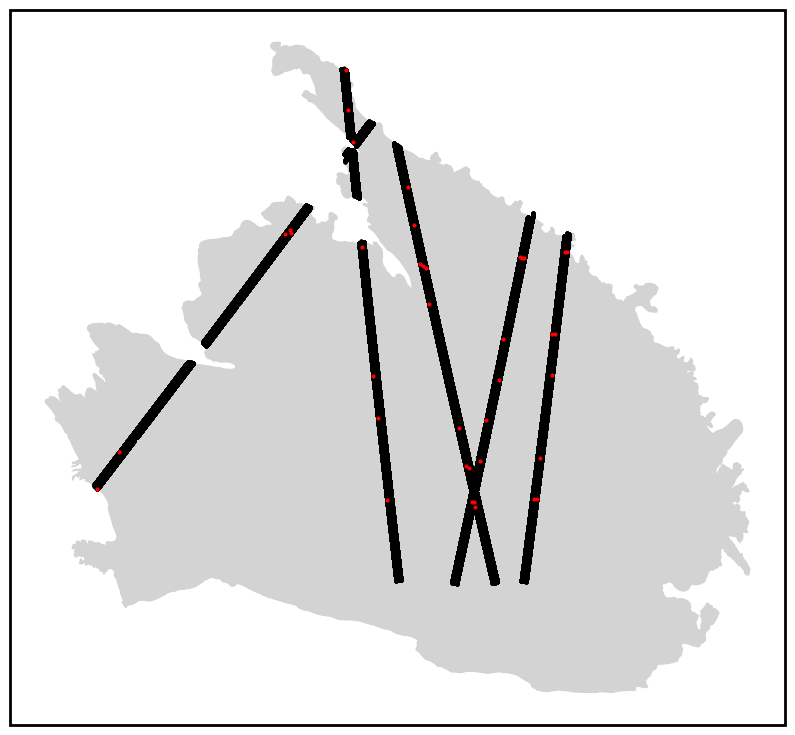

In [179]:
len(crossover_dfs)
# Plot example chosen points
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={"projection": ps71_projection},
)
plot_shapefile(
    filtered_records,
    filtered_shapes,
    ax,
    ["blue", "lightgray"],
    ps71_projection,
    fill=True,
)
for data in data_arr:
    ax.scatter(
        data["x"][data["inside_mask"]],
        data["y"][data["inside_mask"]],
        color="black",
        zorder=5,
        s=4,
    )
for crossover_df in crossover_dfs:
    x, y = ll2xy(crossover_df["lon"][0], crossover_df["lat"][0])
    ax.scatter(x, y, color="red", zorder=6, s=4)

In [249]:
# Get IS2 elevations vs cats elevations for each crossover:
tide_dir = "/mnt/c/users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"
tides = Tides.Tide(tide_mod, tide_dir)
CM_TO_M = 1 / 100
is2_elev_list = []
periods = [constituents[c] for c in constituents]
for crossover_df in crossover_dfs[:]:
    is2_elevs = {
        "times": [],
        "elevations": [],
        "cats_elevations": [],
        "lon": 0,
        "lat": 0,
        "cats_constituents_amp": [],
        "cats_constituents_ph": [],
        "times_mpl": [],
    }
    # Extract crossover_df['h_corr'] masked where q_flag != 0
    mskd_q = crossover_df["q_flag"] == 0
    mskd_h = crossover_df["h_corr"].values[mskd_q]
    mskd_dac = crossover_df["dac"].values[mskd_q]
    data = mskd_h - mskd_dac
    times_mpl = crossover_df["time"].values[mskd_q]
    tide_times = crossover_df["datetime"].values[mskd_q]
    tide_times = [
        datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in tide_times
    ]
    is2_elevs["times"].extend(tide_times)
    is2_elevs["times_mpl"].extend(times_mpl)
    is2_elevs["elevations"].extend(data)
    is2_elevs["lon"] = crossover_df["lon"].iloc[0]
    is2_elevs["lat"] = crossover_df["lat"].iloc[0]

    tide_results, amp, ph = tides.tidal_elevation(
        [crossover_df["lon"].iloc[0]],
        [crossover_df["lat"].iloc[0]],
        tide_times,
    )
    tide_results = tide_results.data.T[0]
    tide_results = tide_results * CM_TO_M
    is2_elevs["cats_elevations"].extend(tide_results)
    is2_elevs["cats_constituents_amp"].extend(amp)
    is2_elevs["cats_constituents_ph"].extend(ph)
    is2_elev_list.append(is2_elevs)

['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']
['m2', 's2', 'n2', 'k2',

In [ ]:
for num, is2_elev in enumerate(is2_elev_list[:]):
    fig, ax0 = plt.subplots(figsize=(12, 4))
    is2_elev["detrended"] = scipy.signal.detrend(is2_elev["elevations"], type="linear")
    ax = fig.add_axes(
        ax0.get_position(), sharex=ax0, sharey=ax0, frameon=False, zorder=20
    )
    ax0.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.scatter(
        is2_elev["times"],
        is2_elev["elevations"],
        s=80,
        label="ICESat-2 ATL11 h_corr - dac",
        marker="+",
        color="#821f48",
        zorder=3,
    )
    ax.scatter(
        is2_elev["times"],
        is2_elev["cats_elevations"],
        s=80,
        color="#576ce7",
        label="CATS Model",
        marker="x",
        zorder=5,
    )
    ax.set_xlabel("Year", fontsize=25)
    ax.set_ylabel("Tide [m]", fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2025, 1, 1))
    # ax.set_ylim(-1.1, 1.99)
    # Set x axis in years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    legend = ax.legend(loc="upper left", fontsize=12, facecolor="gray", framealpha=0.3)
    legend.get_frame().set_boxstyle("Square")

    inset = fig.add_axes(
        [0.55, 0.65, 0.6, 0.6], projection=ps71_projection, zorder=1
    )  # [left, bottom, width, height]
    inset.patch.set_facecolor("none")
    for spine in inset.spines.values():
        spine.set_visible(False)
    inset.set_xticks([])
    inset.set_yticks([])
    plot_shapefile(
        filtered_records,
        filtered_shapes,
        inset,
        ["blue", "lightgray"],
        ps71_projection,
        fill=True,
    )
    x, y = ll2xy(is2_elev["lon"], is2_elev["lat"])
    inset.scatter(x, y, color="black", zorder=6, s=20)
    # fig.savefig(f"{num}_tide_height_notdetrended.png", bbox_inches="tight", dpi=300,transparent=True)

In [264]:
is2_elev["cats_constituents_amp"][0][:8]

masked_array(data=[0.19062653183937073, 0.2353266030550003,
                   0.216408371925354, 0.10323992371559143,
                   0.4983953833580017, 0.39280596375465393,
                   0.17545558512210846, 0.08505567163228989],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

/tmp/ipykernel_6127/1523682657.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


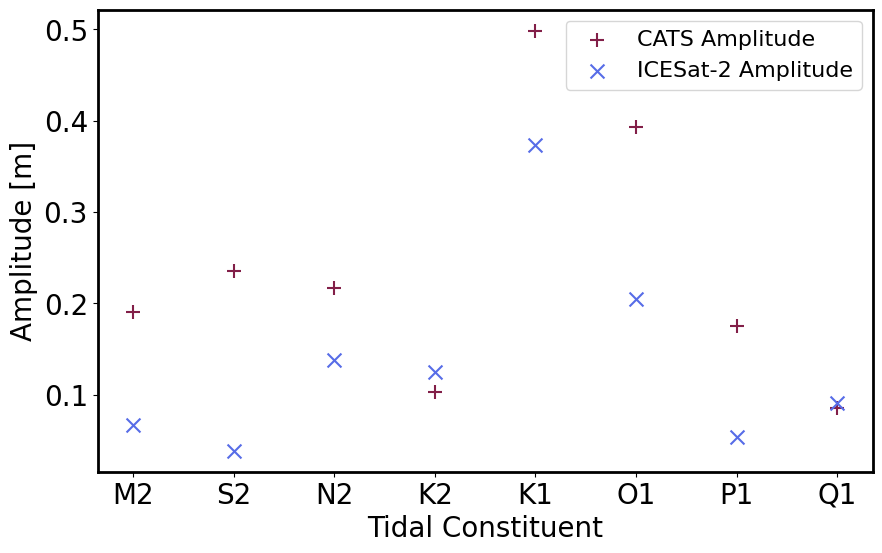

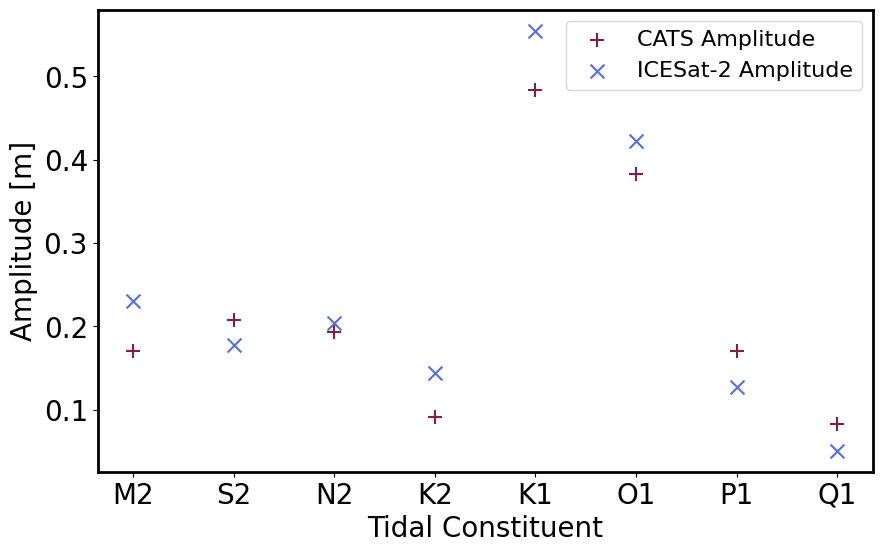

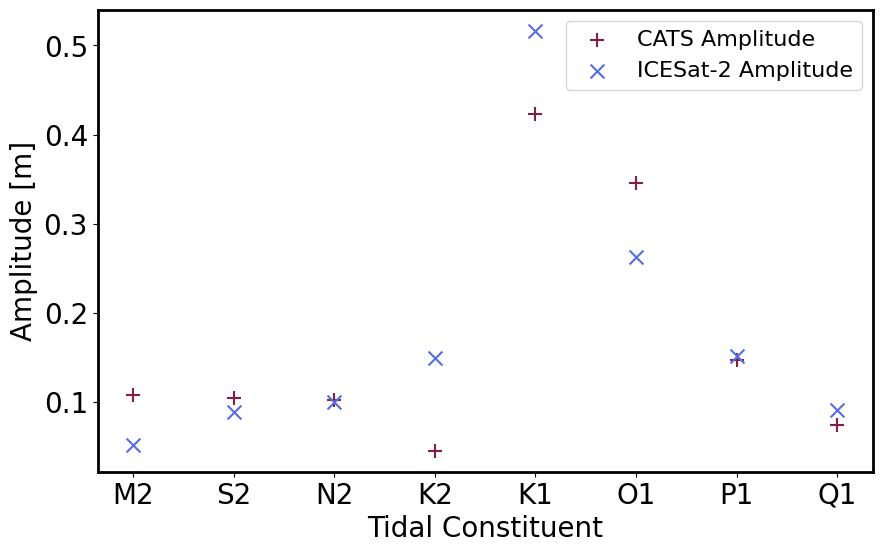

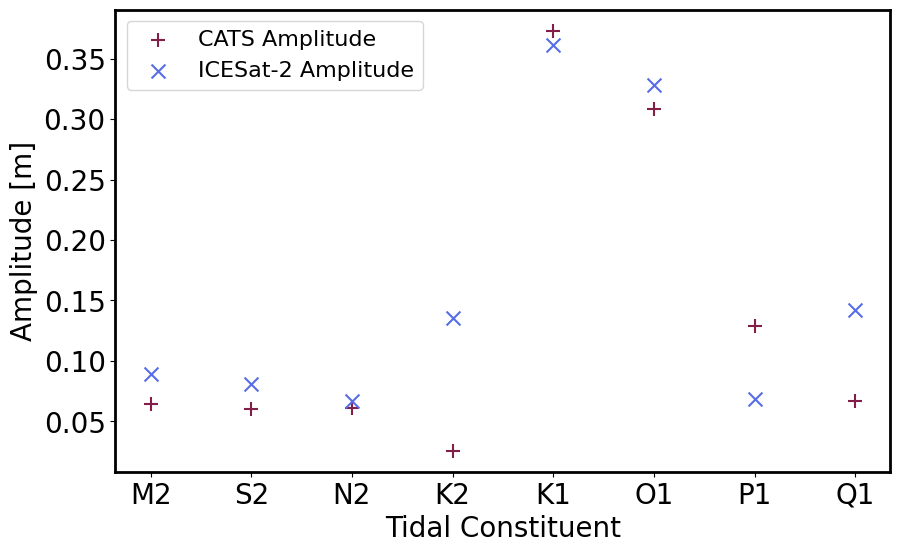

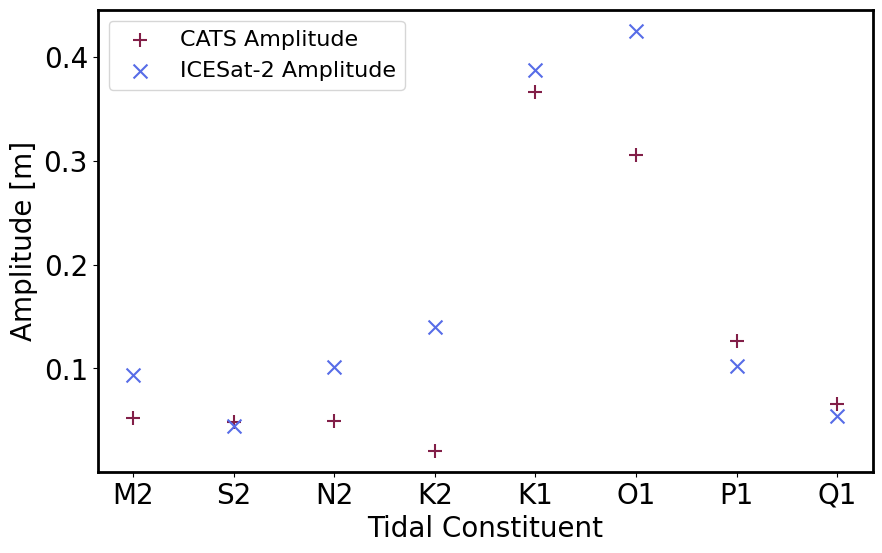

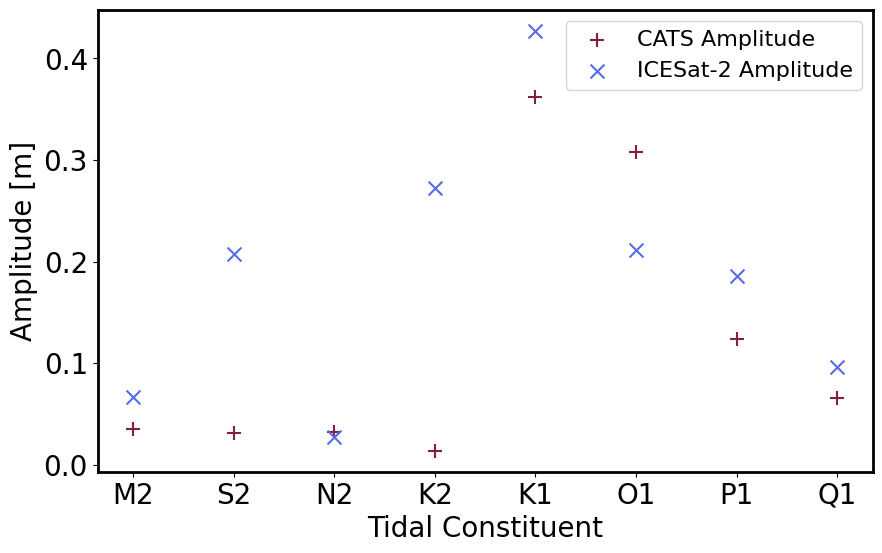

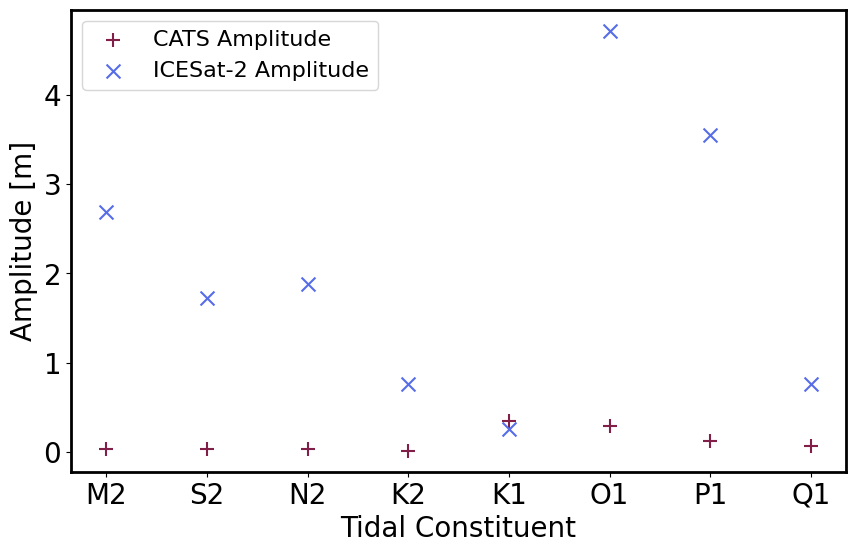

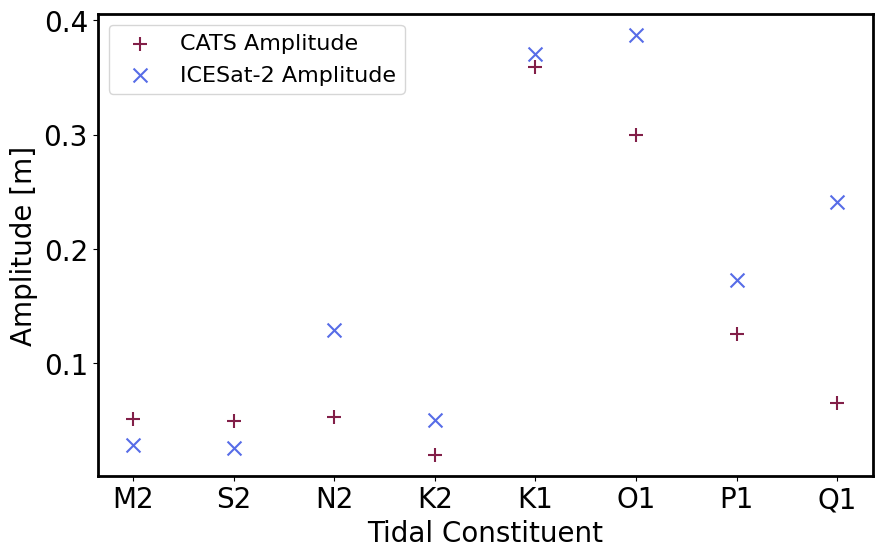

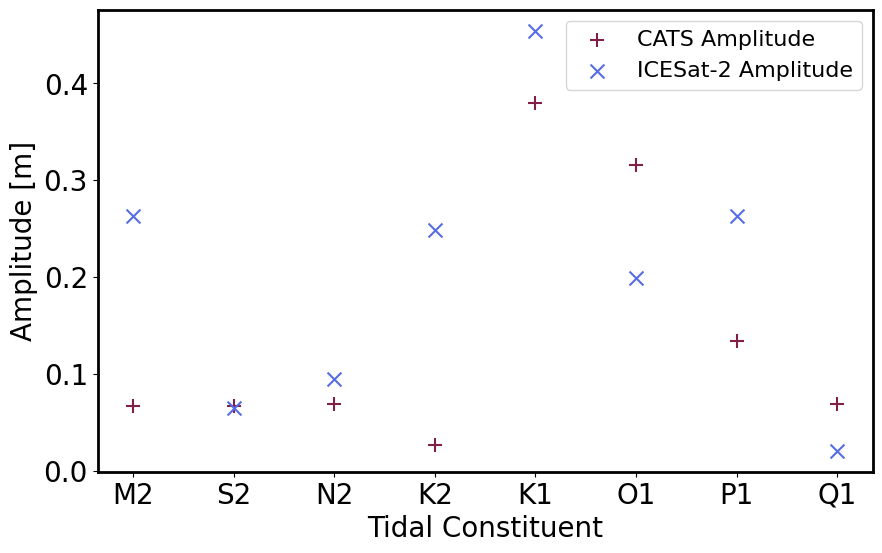

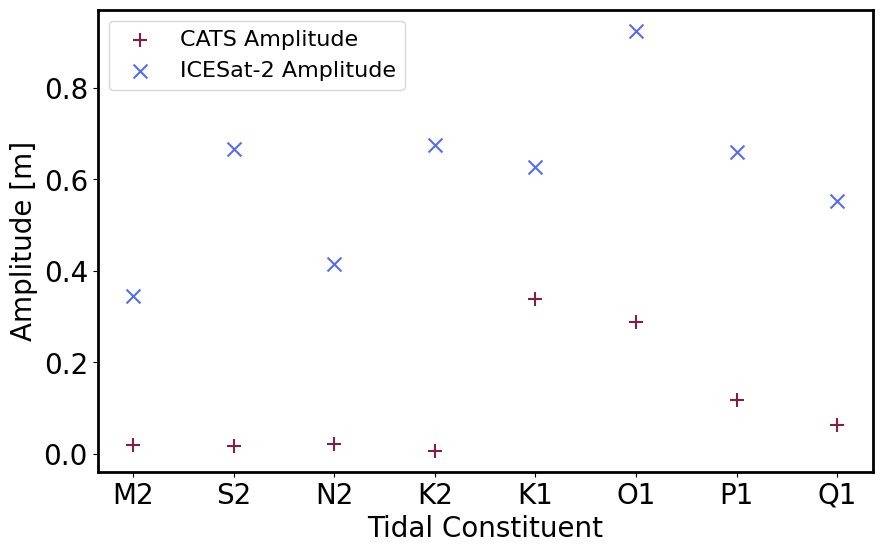

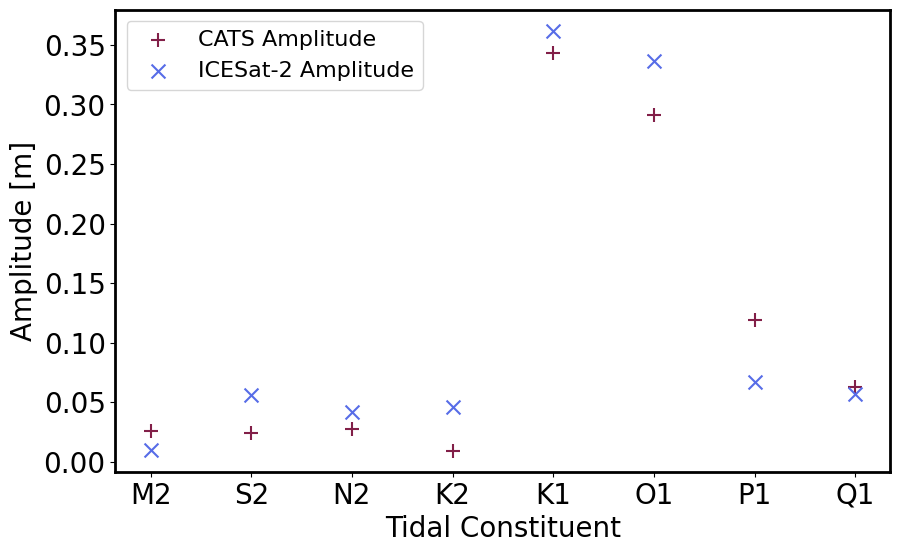

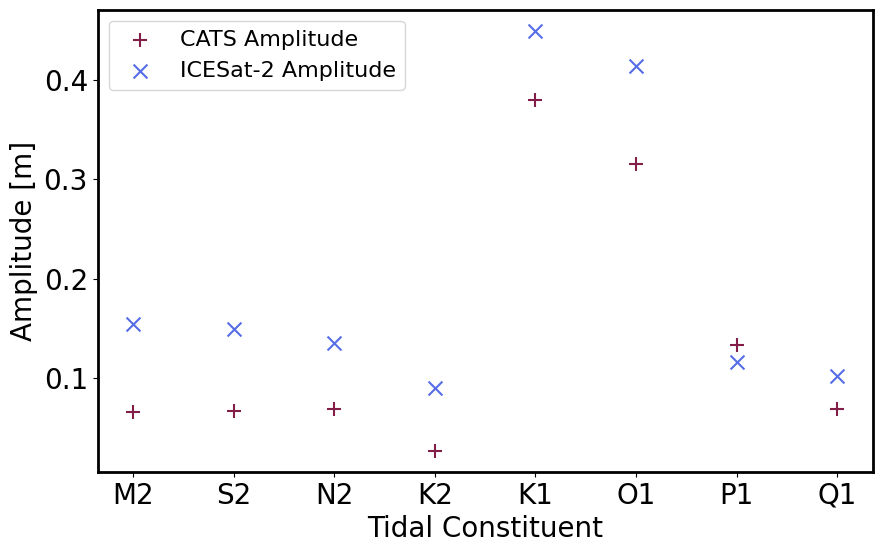

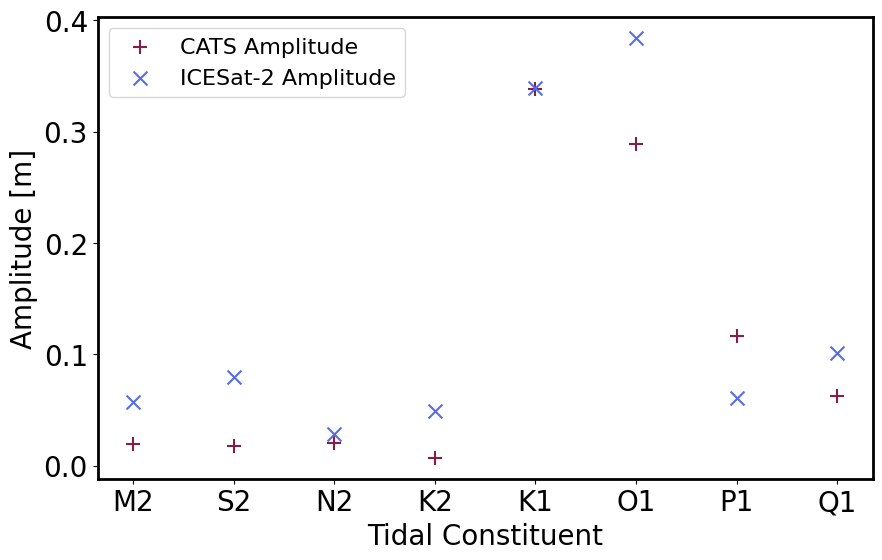

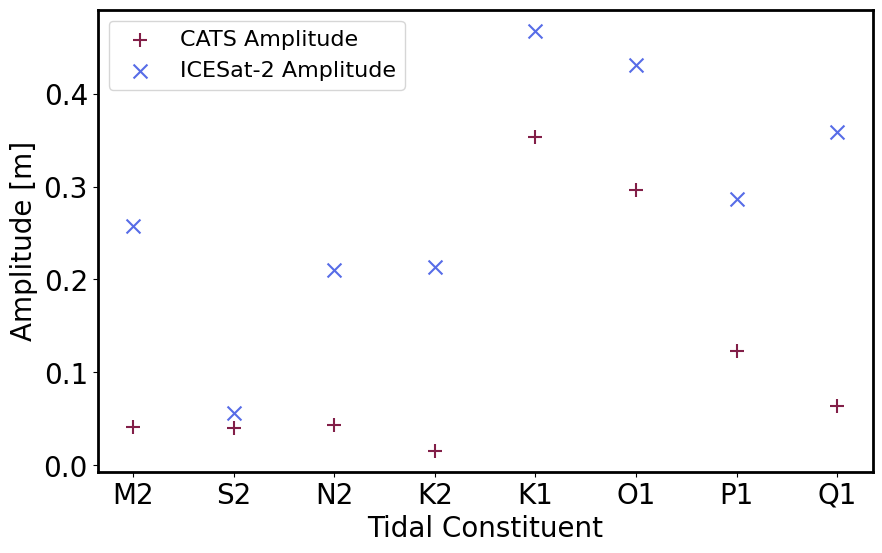

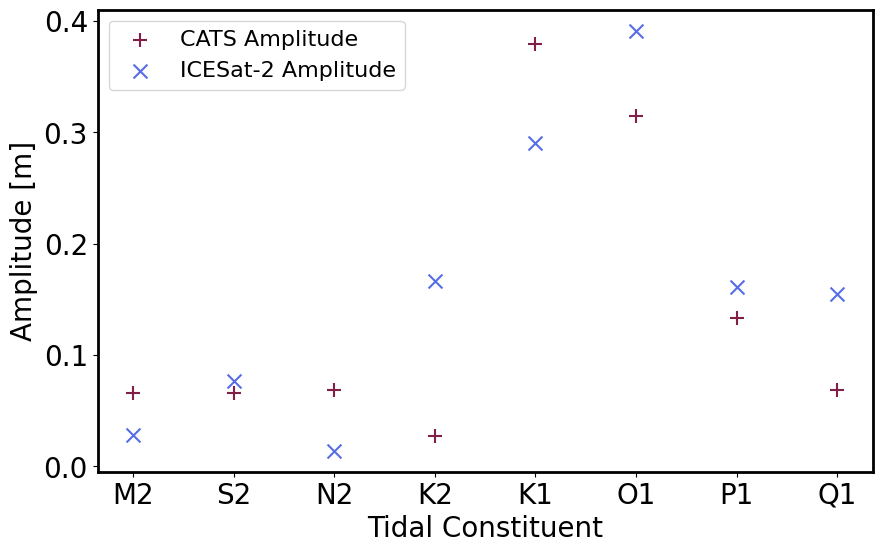

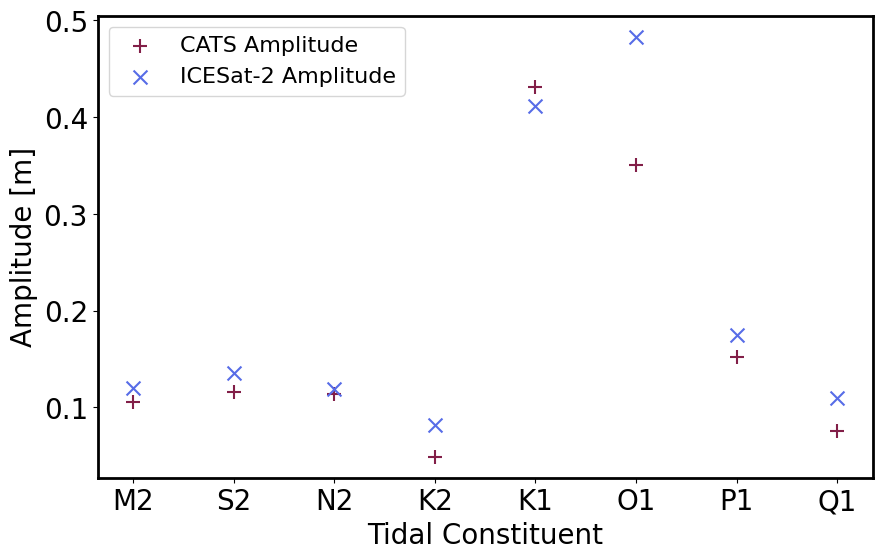

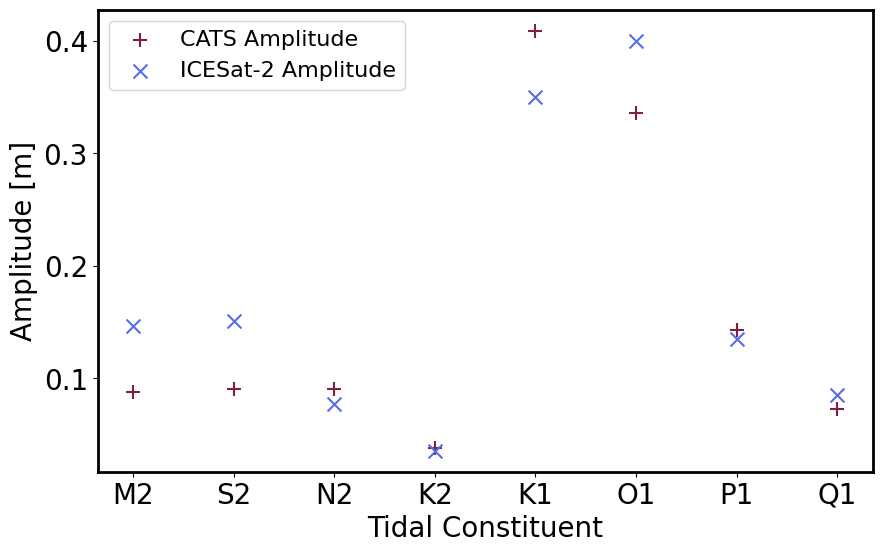

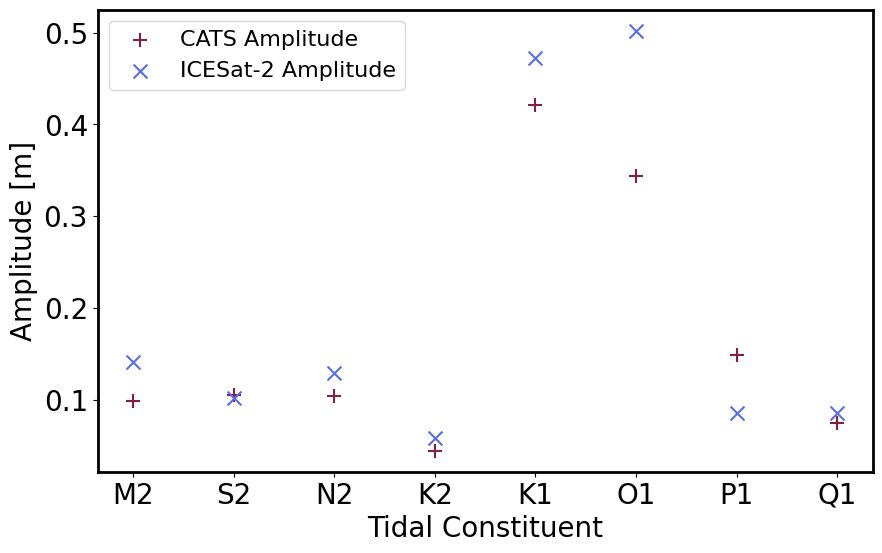

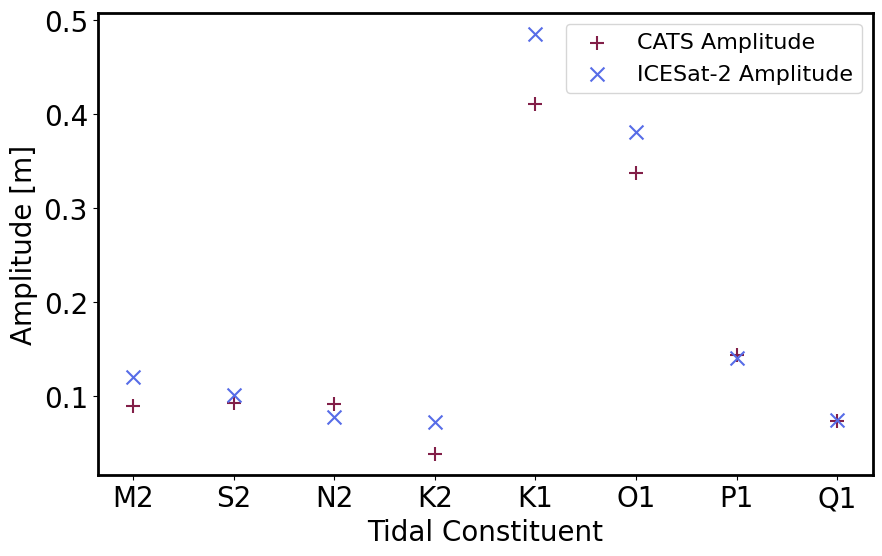

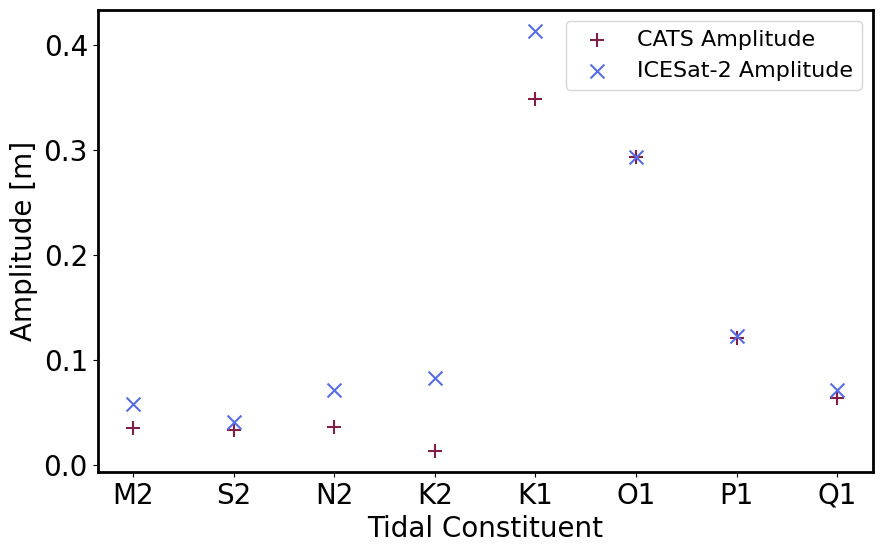

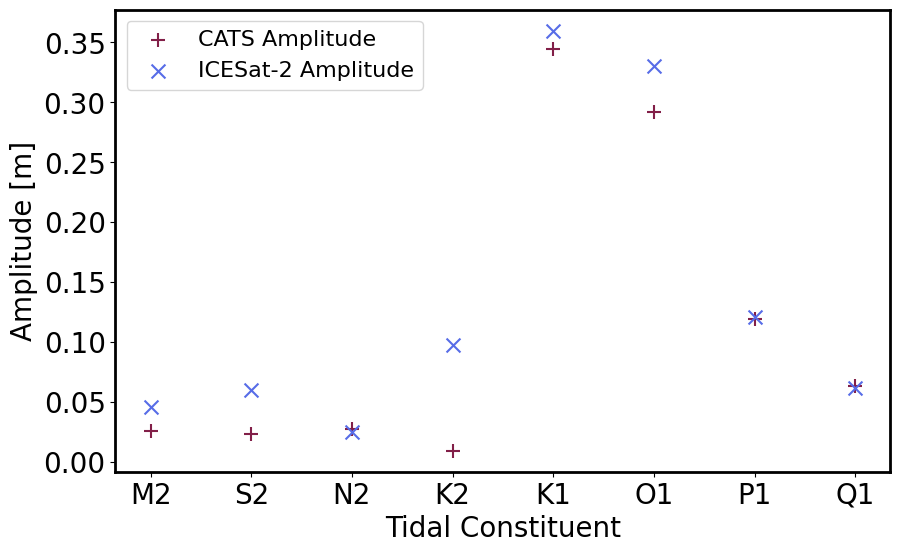

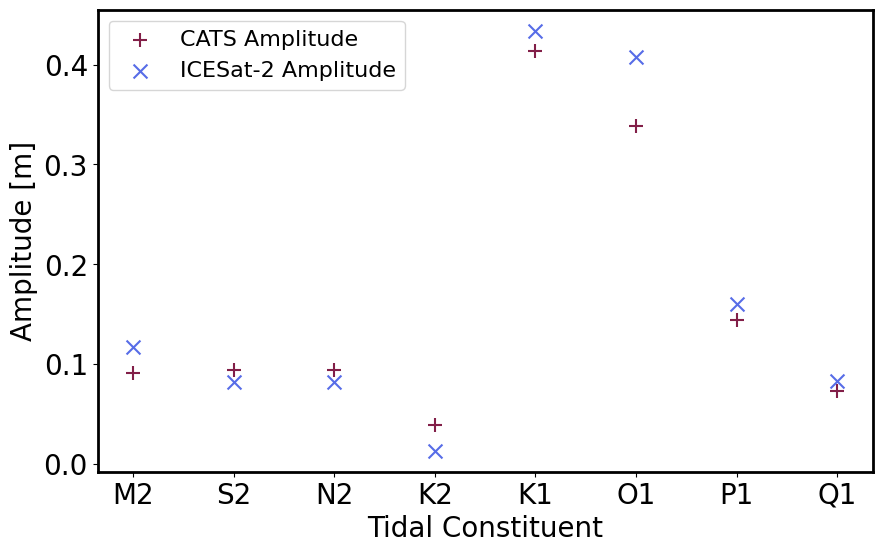

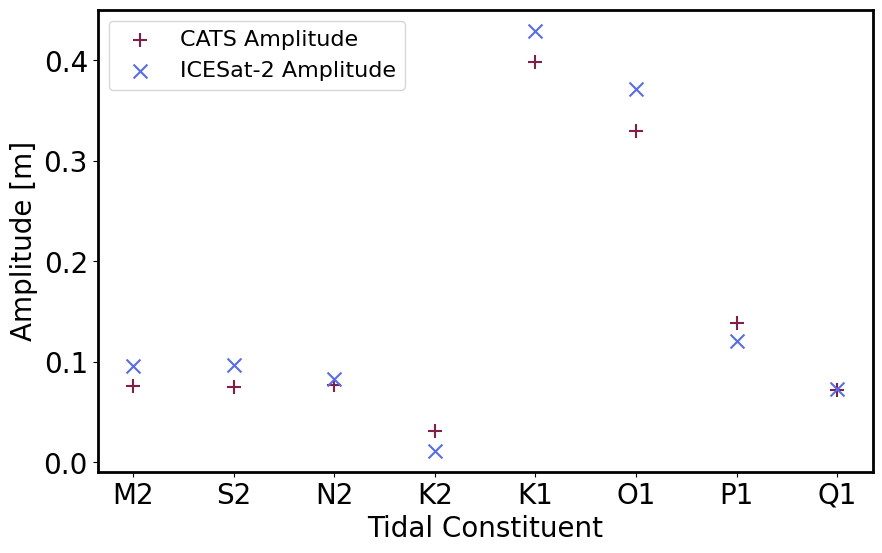

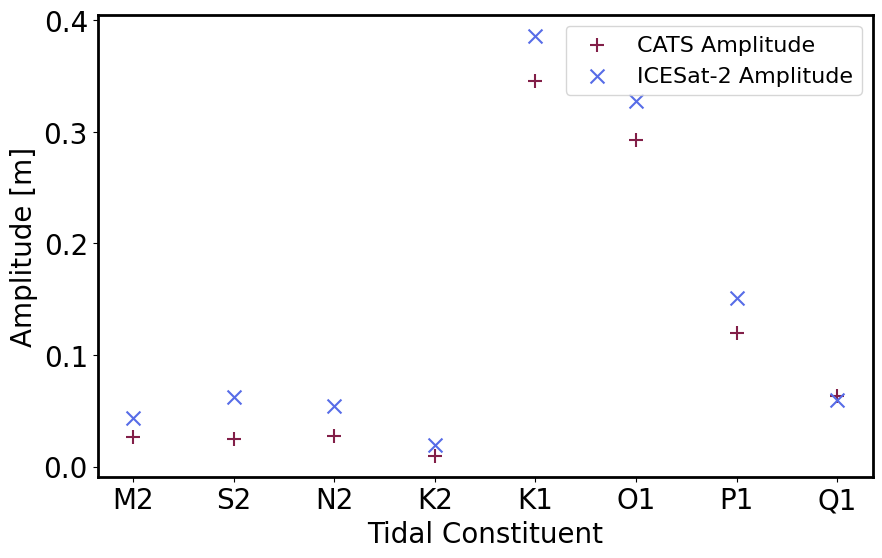

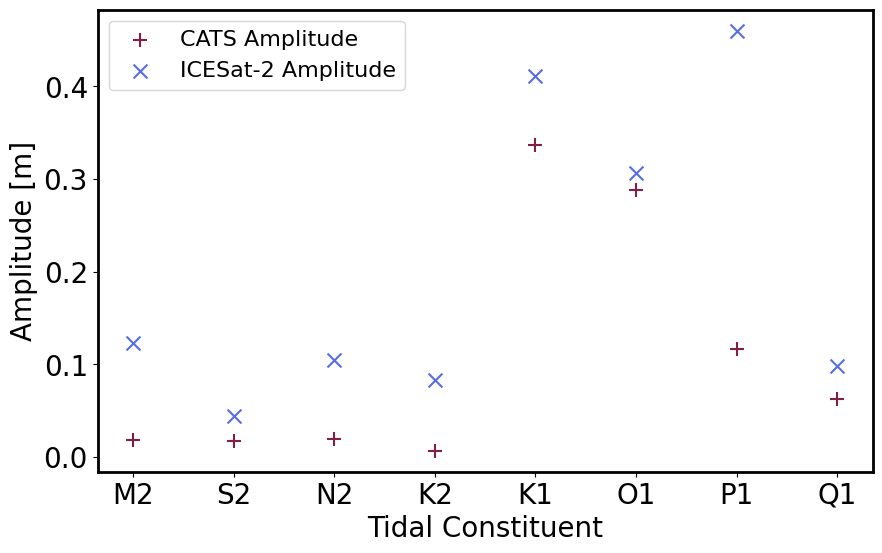

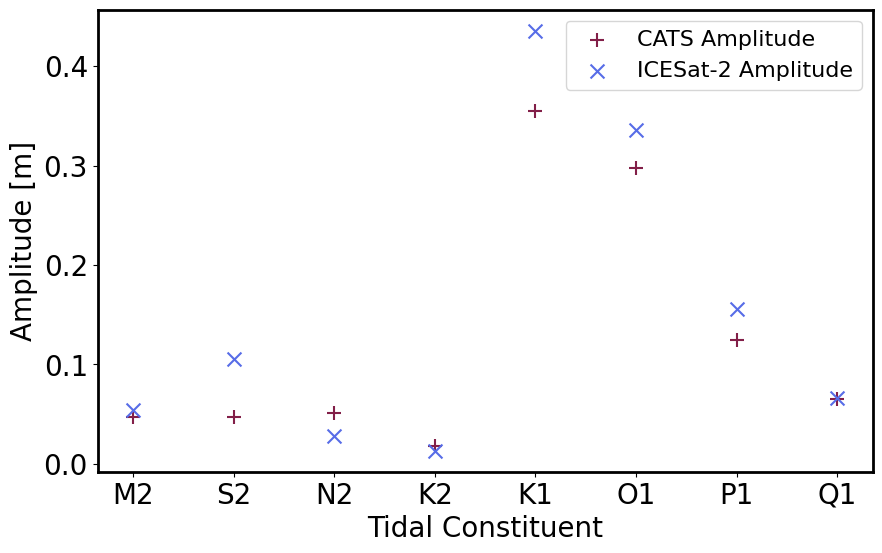

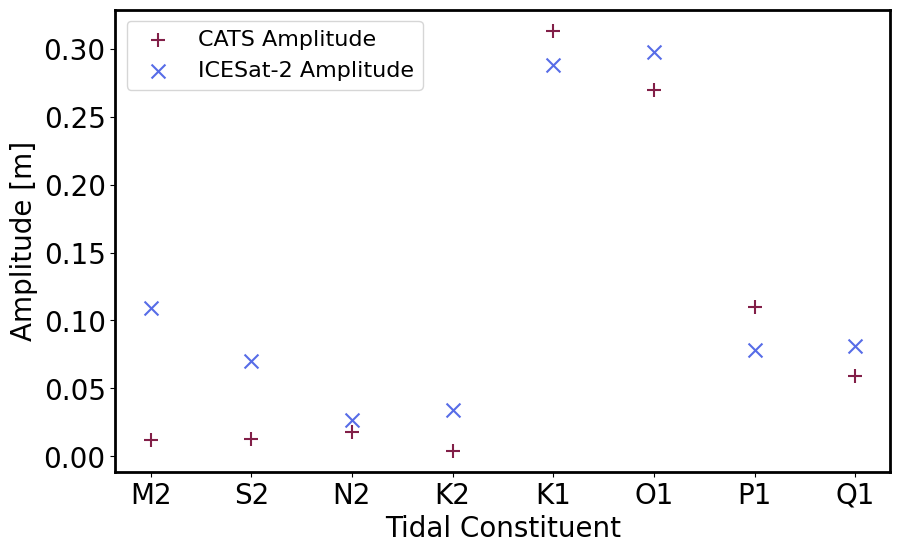

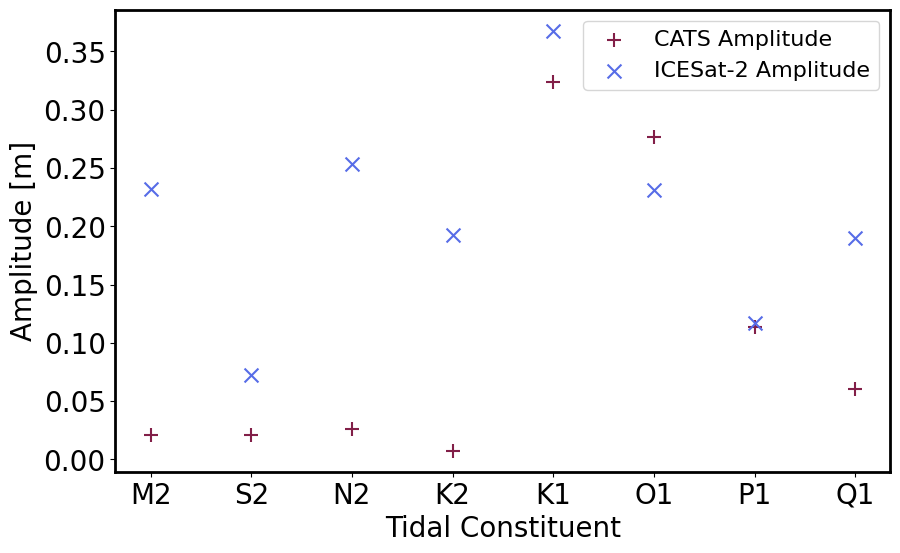

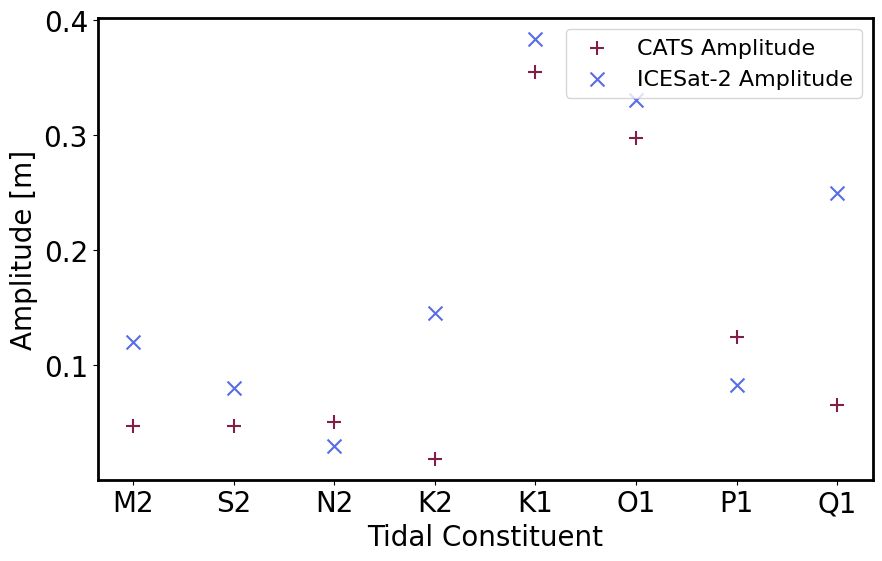

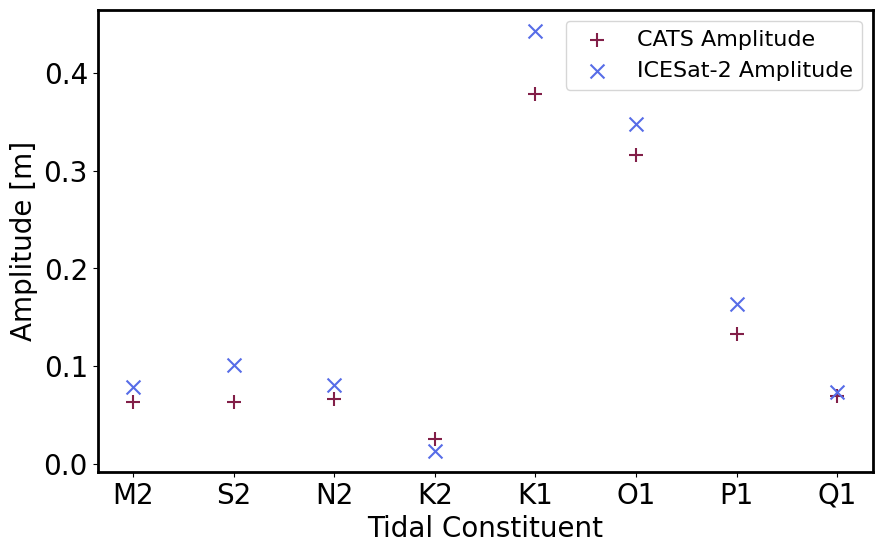

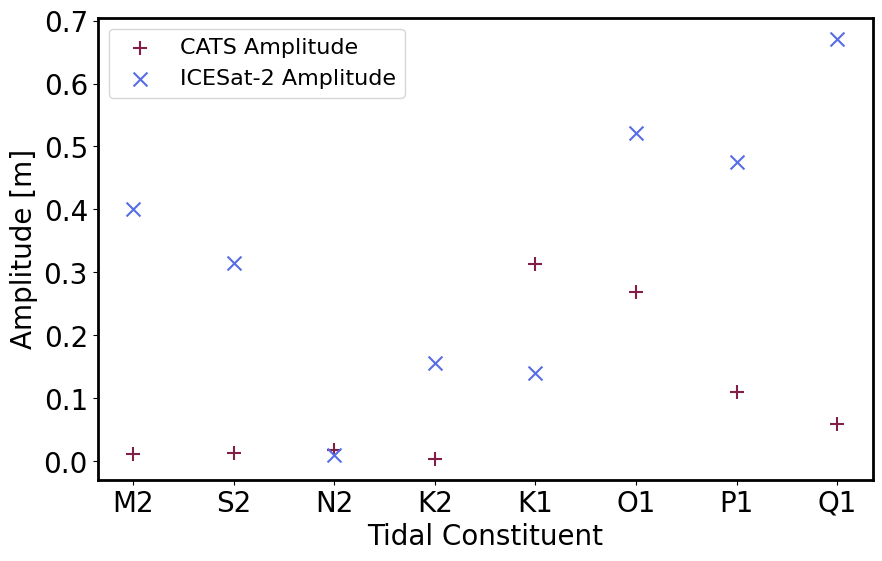

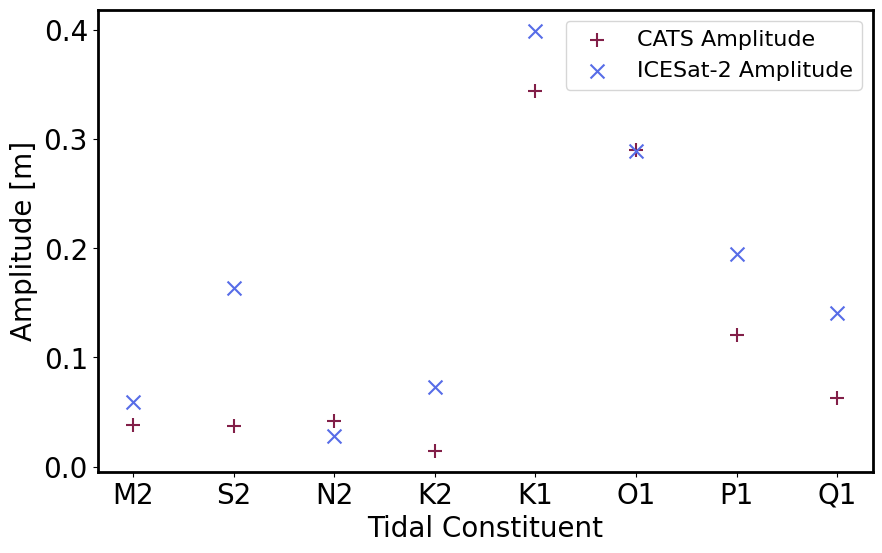

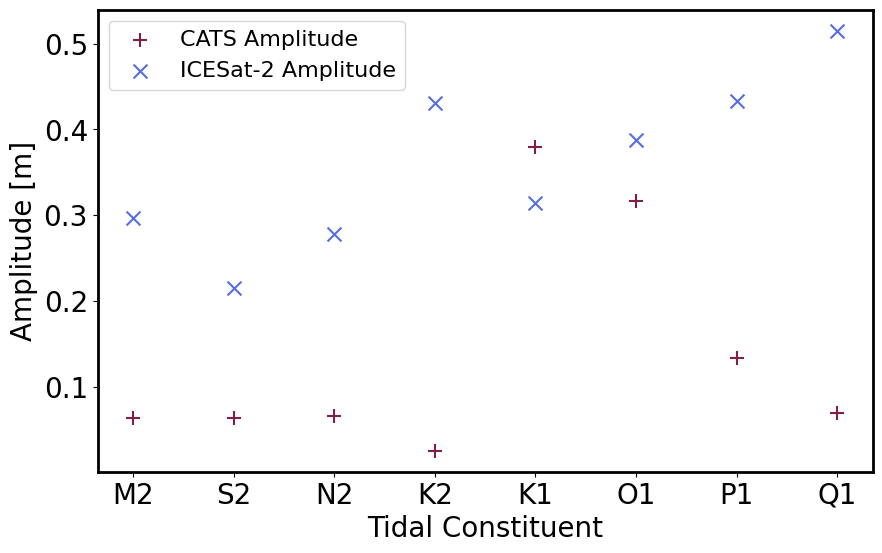

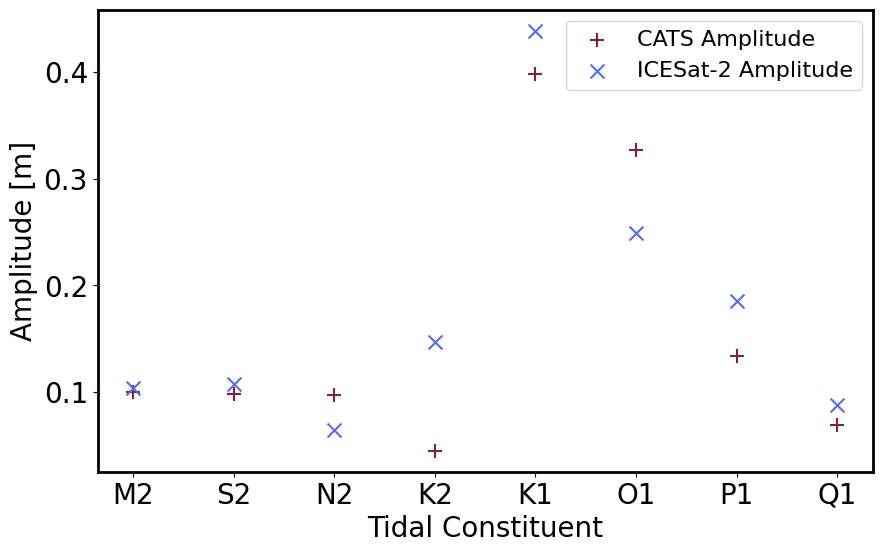

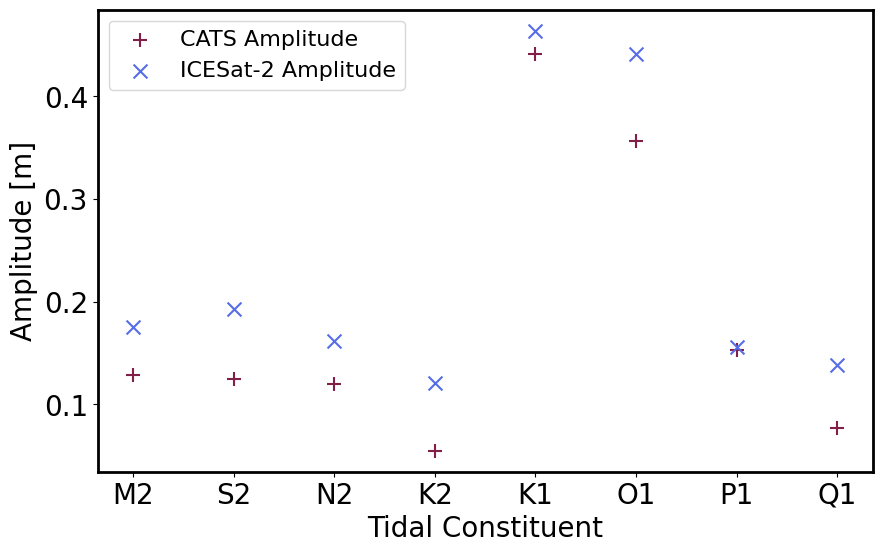

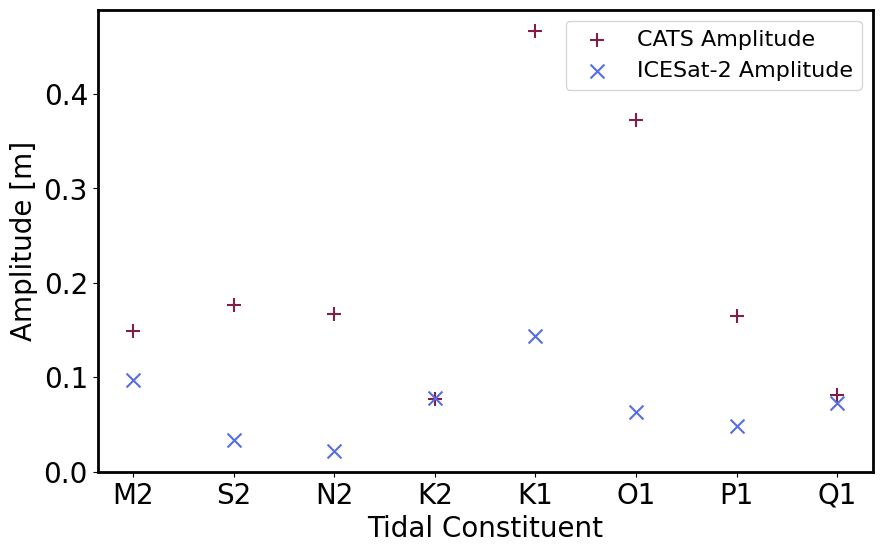

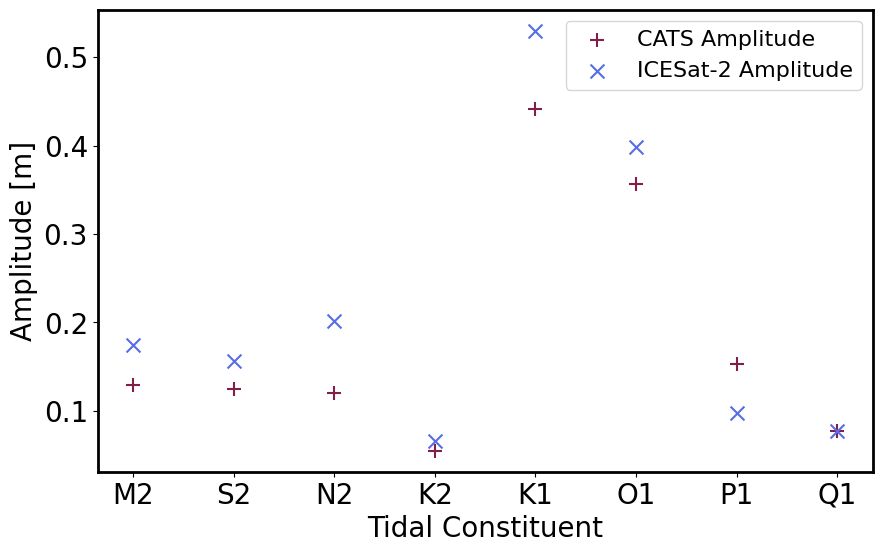

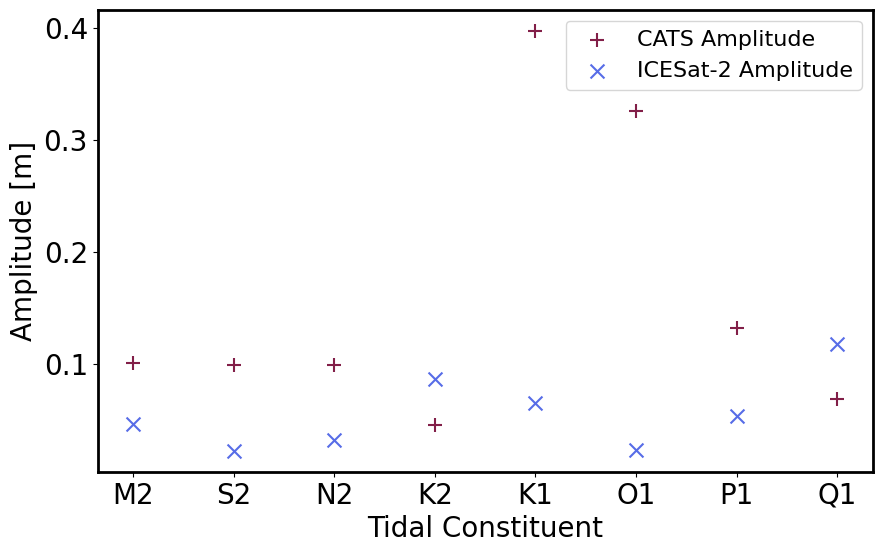

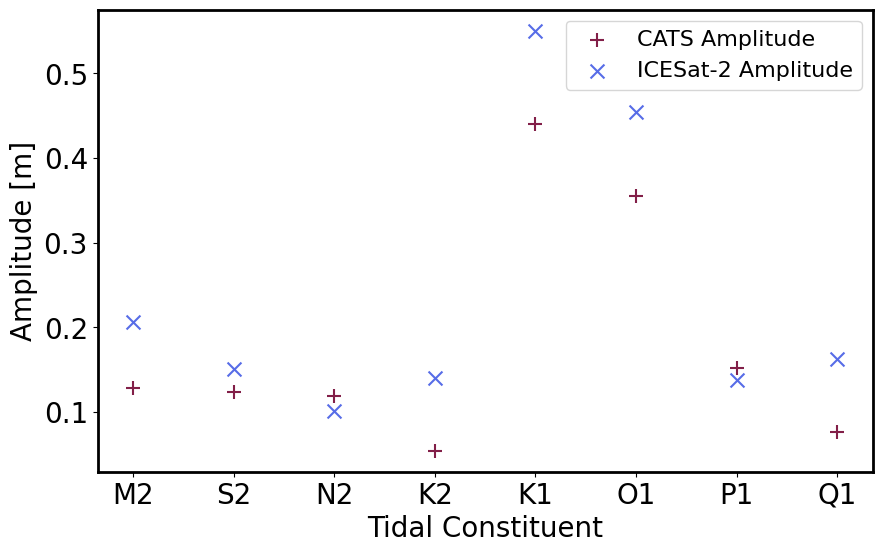

In [272]:
# Now run my harmonic analysis and compare to CATS again
periods = [constituents[c] for c in constituents]
for num, is2_elev in enumerate(is2_elev_list[:]):
    t = is2_elev["times_mpl"]
    t = np.asarray(t, dtype=float)
    data = is2_elev["detrended"]  # Use detrended data
    initial_guess = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    fit = least_squares(residuals, initial_guess, args=(t, data, periods))

    IS2_MYHA = []
    # Print real and fitted parameters
    for true, fitted in zip(is2_elev["cats_constituents_amp"][0][:8], fit.x):
        fitted = np.abs(fitted)
        IS2_MYHA.append(fitted)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(
        range(8),
        is2_elev["cats_constituents_amp"][0][:8],
        color="#821f48",
        label="CATS Amplitude",
        marker="+",
        s=100,
    )
    ax.scatter(
        range(8),
        IS2_MYHA,
        color="#576ce7",
        label="ICESat-2 Amplitude",
        marker="x",
        s=100,
    )
    # print(list(constituents.keys()))
    # ax.set_xticklabels(list(constituents.keys()))
    labels = list(constituents.keys())
    positions = np.arange(len(labels))  # or whatever your x positions are

    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    ax.legend(fontsize=16)
    ax.set_ylabel("Amplitude [m]", fontsize=20)
    ax.set_xlabel("Tidal Constituent", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    fig.savefig(f"{num}_ha.png", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:
### BELOW THIS LINE IS TESTING CODE ###
#######################################

# GZ05 location sanity check
crossover_dfs_GZ05 = []
gz05_lat, gz05_lon = -84.2986, -164.5206

for trk_X in data_arr[-1:]:
    lat_lon = np.column_stack((trk_X["x_lat"], trk_X["x_lon"]))
    dists = np.linalg.norm(lat_lon - [gz05_lat, gz05_lon], axis=1)
    min_index = np.argmin(dists)
    print(lat_lon[min_index], dists[min_index], min_index)
    ref_pts = [trk_X["x_ref_pt"][min_index]]
    for ref_pt in ref_pts:
        mskx = (trk_X["x_ref_pt"] == ref_pt) & (trk_X["x_t_dt"] < 2e300)
        msk = trk_X["ref_pt"] == ref_pt
        if len(trk_X["x_rgt"][mskx]) > 0:  # We have 5+ pts of crossover data here
            print("ref_pt:", ref_pt)
            print(trk_X["x_rgt"][mskx])
            mskd_lat = trk_X["lat"][msk]
            mskd_lon = trk_X["lon"][msk]
            mskd_xlat = trk_X["x_lat"][mskx]
            mskd_xlon = trk_X["x_lon"][mskx]
            mskd_xh = trk_X["x_h_corr"][mskx]

            mskd_h = trk_X["h_corr"][msk]
            msk_h = mskd_h < 1e30
            mskd_h = mskd_h[msk_h]
            mskd_xt = trk_X["x_time"][mskx]
            mskd_xcycle = trk_X["x_cycle_number"][mskx]
            mskd_xrgt = trk_X["x_rgt"][mskx]
            mskd_xrefpt = trk_X["x_ref_pt"][mskx]
            mskd_xdac = trk_X["x_dac"][mskx]
            mskd_xq = trk_X["x_q_flag"][mskx]

            # mskd_xtide = trk_X["x_tide"][mskx]

            mskd_t = trk_X["time"][msk]
            mskd_dac = trk_X["dac"][msk]
            mskd_q = trk_X["q_flag"][msk]

            mskd_tdt = trk_X["t_dt"][msk]
            # mskd_refpt = trk_X["ref_pt"][msk_t]
            # mskd_tide = trk_X["tide"][msk]
            msk_t = mskd_tdt < 1e300
            mskd_t = mskd_t[msk_t]
            mskd_dac = mskd_dac[msk_t]
            mskd_q = mskd_q[msk_t]
            msk_t = msk_t.flatten()
            mskd_cycle = trk_X["cycle_number"][msk_t]

            mskd_lon = np.ones(len(mskd_t)) * mskd_lon
            mskd_lat = np.ones(len(mskd_t)) * mskd_lat
            mskd_rgt = np.ones(len(mskd_t), dtype=int) * int(
                files[0].stem.split("_")[1][:4]
            )

            print(mskd_h, mskd_xh)
            print(
                len(mskd_lat),
                len(mskd_lon),
                len(mskd_t),
                len(mskd_cycle),
                len(mskd_rgt),
                len(mskd_h),
                len(mskd_q),
                # len(mskd_tide),
            )
            print(
                len(mskd_xlat),
                len(mskd_xlon),
                len(mskd_xt),
                len(mskd_xcycle),
                len(mskd_xrgt),
                len(mskd_xh),
                len(mskd_xq),
                # len(mskd_xtide),
            )
            print(mskd_t)
            print(mskd_xt)
            print("lat:", mskd_lat.shape)
            print("lon:", mskd_lon.shape)
            print("t  :", mskd_t.shape)
            print("h  :", mskd_h.shape)
            print("cycle:", mskd_cycle.shape)
            print("rgt:", mskd_rgt.shape)
            print("dac:", mskd_dac.shape)
            print("q_flag:", mskd_q.shape)
            df1 = pd.DataFrame(
                {
                    "lat": mskd_xlat,
                    "lon": mskd_xlon,
                    "time": mskd_xt,
                    "cycle_number": mskd_xcycle,
                    "rgt": mskd_xrgt,
                    "h_corr": mskd_xh,
                    "dac": mskd_xdac,
                    "q_flag": mskd_xq,
                    # "tide": mskd_xtide,
                }
            )
            df2 = pd.DataFrame(
                {
                    "lat": mskd_lat,
                    "lon": mskd_lon,
                    "time": mskd_t,
                    "cycle_number": mskd_cycle,
                    "rgt": mskd_rgt,
                    "h_corr": mskd_h,
                    "dac": mskd_dac,
                    "q_flag": mskd_q,
                    # "tide": mskd_tide,
                }
            )
            df = pd.concat([df1, df2], ignore_index=True)
            df = df.sort_values(by=["time"]).reset_index(drop=True)
            # df = [df[(df["h_corr"] < 80) & (df["h_corr"] > 0)]]

            # Remove mean from h_corr

            df["h_corr_demeaned"] = df["h_corr"] - df["h_corr"].mean()

            # Convert time to hours since first time
            df["datetime"] = df["time"]
            # try:
            df["time"] = (
                pd.to_datetime(df["time"]) - pd.to_datetime(df["time"].iloc[0])
            ).dt.total_seconds() / SEC_IN_HR
            crossover_dfs_GZ05.append(df)
            # except IndexError as e:
            #    print("IndexError:", e)
            #    print("Skipping this crossover due to invalid times")
            print(" ")


crossover_dfs_GZ05[0]

[ -84.31712087 -164.53201887] 0.02175805841276959 45949
ref_pt: 1474587
[1075 1075 1075 1075 1075 1075 1075 1075 1075 1075 1075 1075 1075]
[51.377296 51.090458 50.45213  49.89171  50.6149   50.130802 50.46302
 49.937626 50.271534 50.413715 50.36334  51.588753 51.085804 51.01704
 49.833344 50.096783] [49.59857  50.512424 50.41849  50.796818 51.674965 50.89522  49.843697
 49.78055  50.676613 49.706104 51.162533 51.165497 51.196175]
16 16 16 16 16 16 16
13 13 13 13 13 13 13
['2019-09-23 20:43:14.671' '2019-12-23 16:23:01.637'
 '2020-03-23 12:02:45.595' '2020-09-21 03:22:22.345'
 '2020-12-20 23:02:13.893' '2021-03-21 18:42:04.603'
 '2021-06-20 14:21:55.833' '2021-09-19 10:01:52.873'
 '2021-12-19 05:41:48.877' '2022-03-20 01:21:40.428'
 '2022-06-18 21:01:34.718' '2022-09-17 16:41:28.680'
 '2023-03-18 08:01:04.617' '2023-06-17 03:40:21.798'
 '2024-03-15 14:38:39.500' '2024-09-13 05:58:12.087']
['2019-06-07 16:39:24.579' '2019-09-06 12:19:13.085'
 '2019-12-06 07:59:03.237' '2020-09-03 18:58:2

,lat,lon,time,cycle_number,rgt,h_corr,dac,q_flag,h_corr_demeaned,datetime
0,-84.317121,-164.532019,0.000000,3,1075,49.598572,0.333870,0,-0.955082,2019-06-07 16:39:24.579
1,-84.317121,-164.532019,2179.663474,4,1075,50.512424,0.266841,0,-0.041229,2019-09-06 12:19:13.085
2,-84.317121,-164.532019,2596.063914,4,1075,51.377296,0.279219,0,0.823643,2019-09-23 20:43:14.671
3,-84.317121,-164.532019,4359.327405,5,1075,50.418491,0.066635,0,-0.135162,2019-12-06 07:59:03.237
4,-84.317121,-164.532019,4775.726961,5,1075,51.090458,0.225029,0,0.536804,2019-12-23 16:23:01.637
5,-84.317121,-164.532019,6955.389171,6,1075,50.452129,0.207550,0,-0.101524,2020-03-23 12:02:45.595
6,-84.317121,-164.532019,10898.316406,8,1075,50.796818,0.144738,0,0.243164,2020-09-03 18:58:23.640
7,-84.317121,-164.532019,11314.716046,8,1075,49.891708,0.317123,0,-0.661945,2020-09-21 03:22:22.345
8,-84.317121,-164.532019,13077.980071,9,1075,51.674965,0.286866,0,1.121311,2020-12-03 14:38:12.836
9,-84.317121,-164.532019,13494.380365,9,1075,50.614899,0.323919,0,0.061245,2020-12-20 23:02:13.893


In [127]:
# Plot IS2 elevations vs cats elevations for each crossover:
tide_dir = "/mnt/c/users/ZacharyKatz/Desktop/Research/Background"
tide_mod = "CATS2008-v2023"
tides = Tides.Tide(tide_mod, tide_dir)
CM_TO_M = 1 / 100
is2_elev_list_GZ05 = []
periods = [constituents[c] for c in constituents]
for crossover_df in crossover_dfs_GZ05[:1]:
    is2_elevs_GZ05 = {
        "times": [],
        "elevations": [],
        "cats_elevations": [],
        "lon": 0,
        "lat": 0,
    }
    data = crossover_df["h_corr"].values - crossover_df["dac"].values
    data = scipy.signal.detrend(data, type="linear")
    tide_times = crossover_df["datetime"].values
    tide_times = [
        datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in tide_times
    ]
    is2_elevs_GZ05["times"].extend(tide_times)
    is2_elevs_GZ05["elevations"].extend(data)
    is2_elevs_GZ05["lon"] = crossover_df["lon"].iloc[0]
    is2_elevs_GZ05["lat"] = crossover_df["lat"].iloc[0]

    tide_times = crossover_df["datetime"].values
    tide_times = [
        datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S.%f") for t in tide_times
    ]
    tide_results = tides.tidal_elevation(
        [crossover_df["lon"].iloc[0]],
        [crossover_df["lat"].iloc[0]],
        tide_times,
    ).data.T[0]
    tide_results = tide_results * CM_TO_M
    is2_elevs_GZ05["cats_elevations"].extend(tide_results)
    is2_elev_list_GZ05.append(is2_elevs_GZ05)

['2019-06-07 16:39:24.579' '2019-09-06 12:19:13.085'
 '2019-09-23 20:43:14.671' '2019-12-06 07:59:03.237'
 '2019-12-23 16:23:01.637' '2020-03-23 12:02:45.595'
 '2020-09-03 18:58:23.640' '2020-09-21 03:22:22.345'
 '2020-12-03 14:38:12.836' '2020-12-20 23:02:13.893'
 '2021-03-21 18:42:04.603' '2021-06-20 14:21:55.833'
 '2021-09-02 01:37:52.259' '2021-09-19 10:01:52.873'
 '2021-12-01 21:17:49.454' '2021-12-19 05:41:48.877'
 '2022-03-20 01:21:40.428' '2022-06-01 12:37:40.594'
 '2022-06-18 21:01:34.718' '2022-08-31 08:17:32.618'
 '2022-09-17 16:41:28.680' '2022-11-30 03:57:12.200'
 '2023-03-18 08:01:04.617' '2023-06-17 03:40:21.798'
 '2023-11-28 10:35:19.790' '2024-03-15 14:38:39.500'
 '2024-08-26 21:34:21.657' '2024-09-13 05:58:12.087'
 '2024-11-25 17:13:49.847']
['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mf', 'mm']


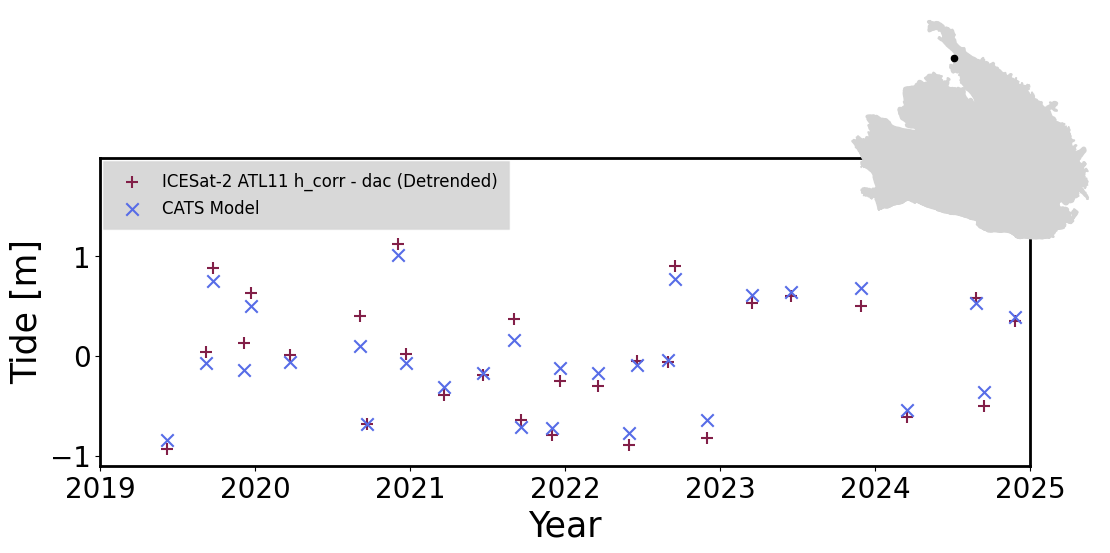

In [145]:
fig, ax = plt.subplots(figsize=(12, 4))
for is2_elev_GZ05 in is2_elev_list_GZ05:
    ax.scatter(
        is2_elev_GZ05["times"],
        is2_elev_GZ05["elevations"],
        s=80,
        label="ICESat-2 ATL11 h_corr - dac (Detrended)",
        marker="+",
        color="#821f48",
    )
    ax.scatter(
        is2_elev_GZ05["times"],
        is2_elev_GZ05["cats_elevations"],
        s=80,
        color="#576ce7",
        label="CATS Model",
        marker="x",
    )
    ax.set_xlabel("Year", fontsize=25)
    ax.set_ylabel("Tide [m]", fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2025, 1, 1))
    ax.set_ylim(-1.1, 1.99)
    # Set x axis in years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    legend = ax.legend(loc="upper left", fontsize=12, facecolor="gray", framealpha=0.3)
    legend.get_frame().set_boxstyle("Square")

    inset = fig.add_axes(
        [0.55, 0.65, 0.6, 0.6], projection=ps71_projection
    )  # [left, bottom, width, height]
    inset.patch.set_facecolor("none")
    for spine in inset.spines.values():
        spine.set_visible(False)
    inset.set_xticks([])
    inset.set_yticks([])
    plot_shapefile(
        filtered_records,
        filtered_shapes,
        inset,
        ["blue", "lightgray"],
        ps71_projection,
        fill=True,
    )
    x, y = ll2xy(is2_elev_GZ05["lon"], is2_elev_GZ05["lat"])
    inset.scatter(x, y, color="black", zorder=6, s=20)
    fig.savefig("gz05_tide_height.png", bbox_inches="tight", dpi=300, transparent=True)